# __ML Unige 2023: Advertisement Impact Prediction__
## Predicting customer subscriptions from an advertisement campaign
### Liam Phan, Michael Bigler and Manuela Giansante

***

# __Goal__

A company wants to assess the quality of their online advertisement campaign. Online users are the main interest in this campaign. The users see a web banner during their browsing activity. For each user, they want to be able to predict whether they subscribe to the advertised product through the advertisement banner, based on the information they have about them. To subscribe, the user has to click on the banner and then subscribe to the service.

The target variable name is __subscription__.

# __Packages__

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
# Color palette
main_col = "#274156"
second_col = "#A2A77F"
target_col = "#499167"

# __Data__

__File descriptions__

***

MLUnige2023_subscriptions_train.csv - The training set (features + response).

MLUnige2023_subscriptions_test.csv - The test set (features only).

MLUnige2023_sampleSubmission.csv - A sample submission file in the correct format (with random predictions).

<br>

__Data fields__

***

__Unique identifier__

1. __Id__: a unique identifier of the observations in each dataset. In the test set, it is used to match your predictions with the true values.

<br>

__Target variable (only in the training data)__

2. __subscription__: whether the user subscribed through the banner (1:yes, 0:no)

<br>

__Demographic variables__

3. __age__: (numeric)

4. __job__: type of job (categorical: teacher, industrial_worker, entrepreneur, housekeeper, manager, retired, freelance, salesman, student, technology, unemployed, na)

5. __marital__: marital status (categorical: married, divorced, single)

6. __education__: (categorical: high_school, university, grad_school, na)

<br>

__Variables about the current campaign__

7. __device__: from which device does the user see the banner? (categorical: smartphone, desktop, na)

8. __day__: last day of the month when the user saw the banner (numeric)

9. __month__: last month of the year when the user saw the banner (numeric)

10. __time_spent__: how long the user looked at the banner last time (in seconds) (numeric)

11. __banner_views__: number of times the user saw the banner (numeric)

<br>

__Variables about an old campaign for the same product__

12. __banner_views_old__: number of times the user saw the banner during an old (and related) online ads campaign (numeric)

13. __days_elapsed_old__: number of days since the user saw the banner of an old (and related) online ads campaign (numeric, -1 if the user never saw the banner)

14. __outcome_old__: outcome of the old (and related) online ads campaign (categorical: failure, other, success, na)

<br>

__Variables with no name__

15. __X1__: (categorical: 1, 0)

16. __X2__: (categorical: 1, 0)

17. __X3__: (categorical: 1, 0)

18. __X4__: (numeric)

***

<br>

We first start by loading both __Datasets__ and assign the correct data type to each column. There could be a debate about using the month and day column as numeric data but in this case we opted to take it as categorical ones. We also assign variables which will alow us to select cateogrical and numerical data as we need this due to different EDA procedures for these types of data.

In [18]:
# Train
train =  pd.read_csv('DATA/MLUnige2023_subscriptions_train.csv', index_col='Id', na_values='na', header=0)
train = train.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'category', 'X2':'category', 'X3':'category', 'X4':'float64', 'subscription':'category', 'day':'category', 'month':'category'})
train.day = pd.Categorical(train.day, ordered=True)
train.month = pd.Categorical(train.month, ordered=True)

train_categorical = list(train.select_dtypes(include=['category']).columns)
train_numeric = list(train.select_dtypes(include=['int64', 'float64']).columns)

train_numeric_target = train_numeric.copy()
train_numeric_target.append("subscription")

# Test
test =  pd.read_csv('DATA/MLUnige2023_subscriptions_test.csv', index_col='Id', na_values='na', header=0)
test = test.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'category', 'X2':'category', 'X3':'category', 'X4':'float64', 'day':'category', 'month':'category'})
test.day = pd.Categorical(test.day, ordered=True)
test.month = pd.Categorical(test.month, ordered=True)

test_categorical = list(test.select_dtypes(include=['category']).columns)
test_numeric = list(test.select_dtypes(include=['int64', 'float64']).columns)

Here we can see some rows of our __Train__ Dataset:

In [19]:
train

age                job   marital    education      device day month  \
Id                                                                          
0      28          freelance   married  grad_school  smartphone   4     2   
1      48  industrial_worker   married   university  smartphone  30     4   
2      27            teacher   married   university  smartphone  14     7   
3      44         unemployed  divorced   university  smartphone  13     5   
4      29            manager    single  grad_school  smartphone  26     4   
...   ...                ...       ...          ...         ...  ..   ...   
8947   54  industrial_worker   married   university  smartphone  16     7   
8948   43  industrial_worker   married   university  smartphone   4     2   
8949   27            manager    single  grad_school         NaN   5     6   
8950   77            retired  divorced  grad_school  smartphone  14     4   
8951   33         technology    single  grad_school  smartphone   4     5   

      time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                   
0          26.80             3                 4               196   
1          13.05             1                 1                79   
2           8.10             3                 0                -1   
3           7.10             2                 1               369   
4          15.90             2                 2               143   
...          ...           ...               ...               ...   
8947        7.30             1                 0                -1   
8948       37.75             2                 0                -1   
8949       29.00             3                 0                -1   
8950        7.55             1                 0                -1   
8951       29.10             1                 1                66   

     outcome_old X1 X2 X3        X4 subscription  
Id                                                
0        failure  0  0  1  0.072803            1  
1        success  0  0  0  0.075454            1  
2            NaN  0  1  1  0.068110            0  
3          other  0  0  1  0.091942            0  
4        success  0  0  0  0.085922            1  
...          ... .. .. ..       ...          ...  
8947         NaN  1  0  0  0.072803            0  
8948         NaN  0  0  1  0.081456            1  
8949         NaN  0  0  1  0.079186            1  
8950         NaN  0  0  0  0.115102            1  
8951     success  0  0  1  0.087656            1  

[8952 rows x 17 columns]

In [20]:
print("We have",train.shape[0], "Rows and", train.shape[1],"Columns in our training data set including the subscription column.")

We have 8952 Rows and 17 Columns in our training data set including the subscription column.


Here is our __Test__ Dataset:

In [21]:
test

age                job   marital    education      device day month  \
Id                                                                          
0      53            retired   married   university         NaN  17     6   
1      61            manager   married  grad_school  smartphone  20     4   
2      51  industrial_worker   married   university         NaN   4     7   
3      34            manager   married  grad_school         NaN  28     5   
4      30            manager   married  grad_school  smartphone   4     5   
...   ...                ...       ...          ...         ...  ..   ...   
3832   47  industrial_worker   married          NaN         NaN   5     6   
3833   30            teacher    single   university  smartphone   3     3   
3834   55            teacher   married   university         NaN  26     6   
3835   46            teacher  divorced   university  smartphone  13     2   
3836   53         technology   married   university     desktop  17     4   

      time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                   
0           5.25             1                 0                -1   
1           9.00             1                 0                -1   
2           9.65             1                 0                -1   
3          13.45             2                 0                -1   
4          16.15             2                 0                -1   
...          ...           ...               ...               ...   
3832       19.20             2                 0                -1   
3833        3.65             1                 0                -1   
3834        5.15             5                 0                -1   
3835        5.55             1                 0                -1   
3836       15.50             3                 1               180   

     outcome_old X1 X2 X3        X4  
Id                                   
0            NaN  0  0  1  0.084570  
1            NaN  0  0  0  0.075227  
2            NaN  0  0  0  0.075781  
3            NaN  0  0  1  0.070043  
4            NaN  0  0  0  0.171618  
...          ... .. .. ..       ...  
3832         NaN  0  0  1  0.104216  
3833         NaN  1  0  0  0.077552  
3834         NaN  0  0  1  0.129156  
3835         NaN  0  0  0  0.093067  
3836     success  0  0  1  0.120949  

[3837 rows x 16 columns]

In [22]:
print("We have",test.shape[0], "Rows and", test.shape[1],"Columns (We don't know the subscription outcome of the test data)")

We have 3837 Rows and 16 Columns (We don't know the subscription outcome of the test data)


# __Exploratory Data Analysis__

After loading the data we now continue with the exploratory data analysis. 

## __Duplicates__

We check if there is any perfect __duplicates__ in both our Datasets:

In [23]:
# Train
## check for duplicate rows
duplicates = train.duplicated()

## display the duplicate rows
print("\n",train[duplicates])

# Test
## check for duplicate rows
duplicates = test.duplicated()

## display the duplicate rows
print("\n",test[duplicates])


 Empty DataFrame
Columns: [age, job, marital, education, device, day, month, time_spent, banner_views, banner_views_old, days_elapsed_old, outcome_old, X1, X2, X3, X4, subscription]
Index: []

 Empty DataFrame
Columns: [age, job, marital, education, device, day, month, time_spent, banner_views, banner_views_old, days_elapsed_old, outcome_old, X1, X2, X3, X4]
Index: []


The dataframes __Train__ and __Test__ have no duplicate rows. 

## __Missing Values__

We then check how many and where are our __missings__ values in both __Train__ and __Test__.

### Train

In [24]:
train.isna().sum()

age                    0
job                   61
marital                0
education            378
device              2050
day                    0
month                  0
time_spent             0
banner_views           0
banner_views_old       0
days_elapsed_old       0
outcome_old         6804
X1                     0
X2                     0
X3                     0
X4                     0
subscription           0
dtype: int64

### Test

In [25]:
test.isna().sum()

age                    0
job                   21
marital                0
education            160
device               901
day                    0
month                  0
time_spent             0
banner_views           0
banner_views_old       0
days_elapsed_old       0
outcome_old         2937
X1                     0
X2                     0
X3                     0
X4                     0
dtype: int64

In both Datasets, we have a lot of __missings__ in __outcome_old__, __device__, __education__ and __job__

We also know that __day_elapsed_old__ is having the same __missings__ as __outcome_old__, just encoded as -1 instead. We can also __visualize__ it with a plot:

### Train

Here we see the missing values plot for the training data sorted by the columns with the most missing values to the left. 

Text(0.5, 1.0, 'Missing Values on Train')

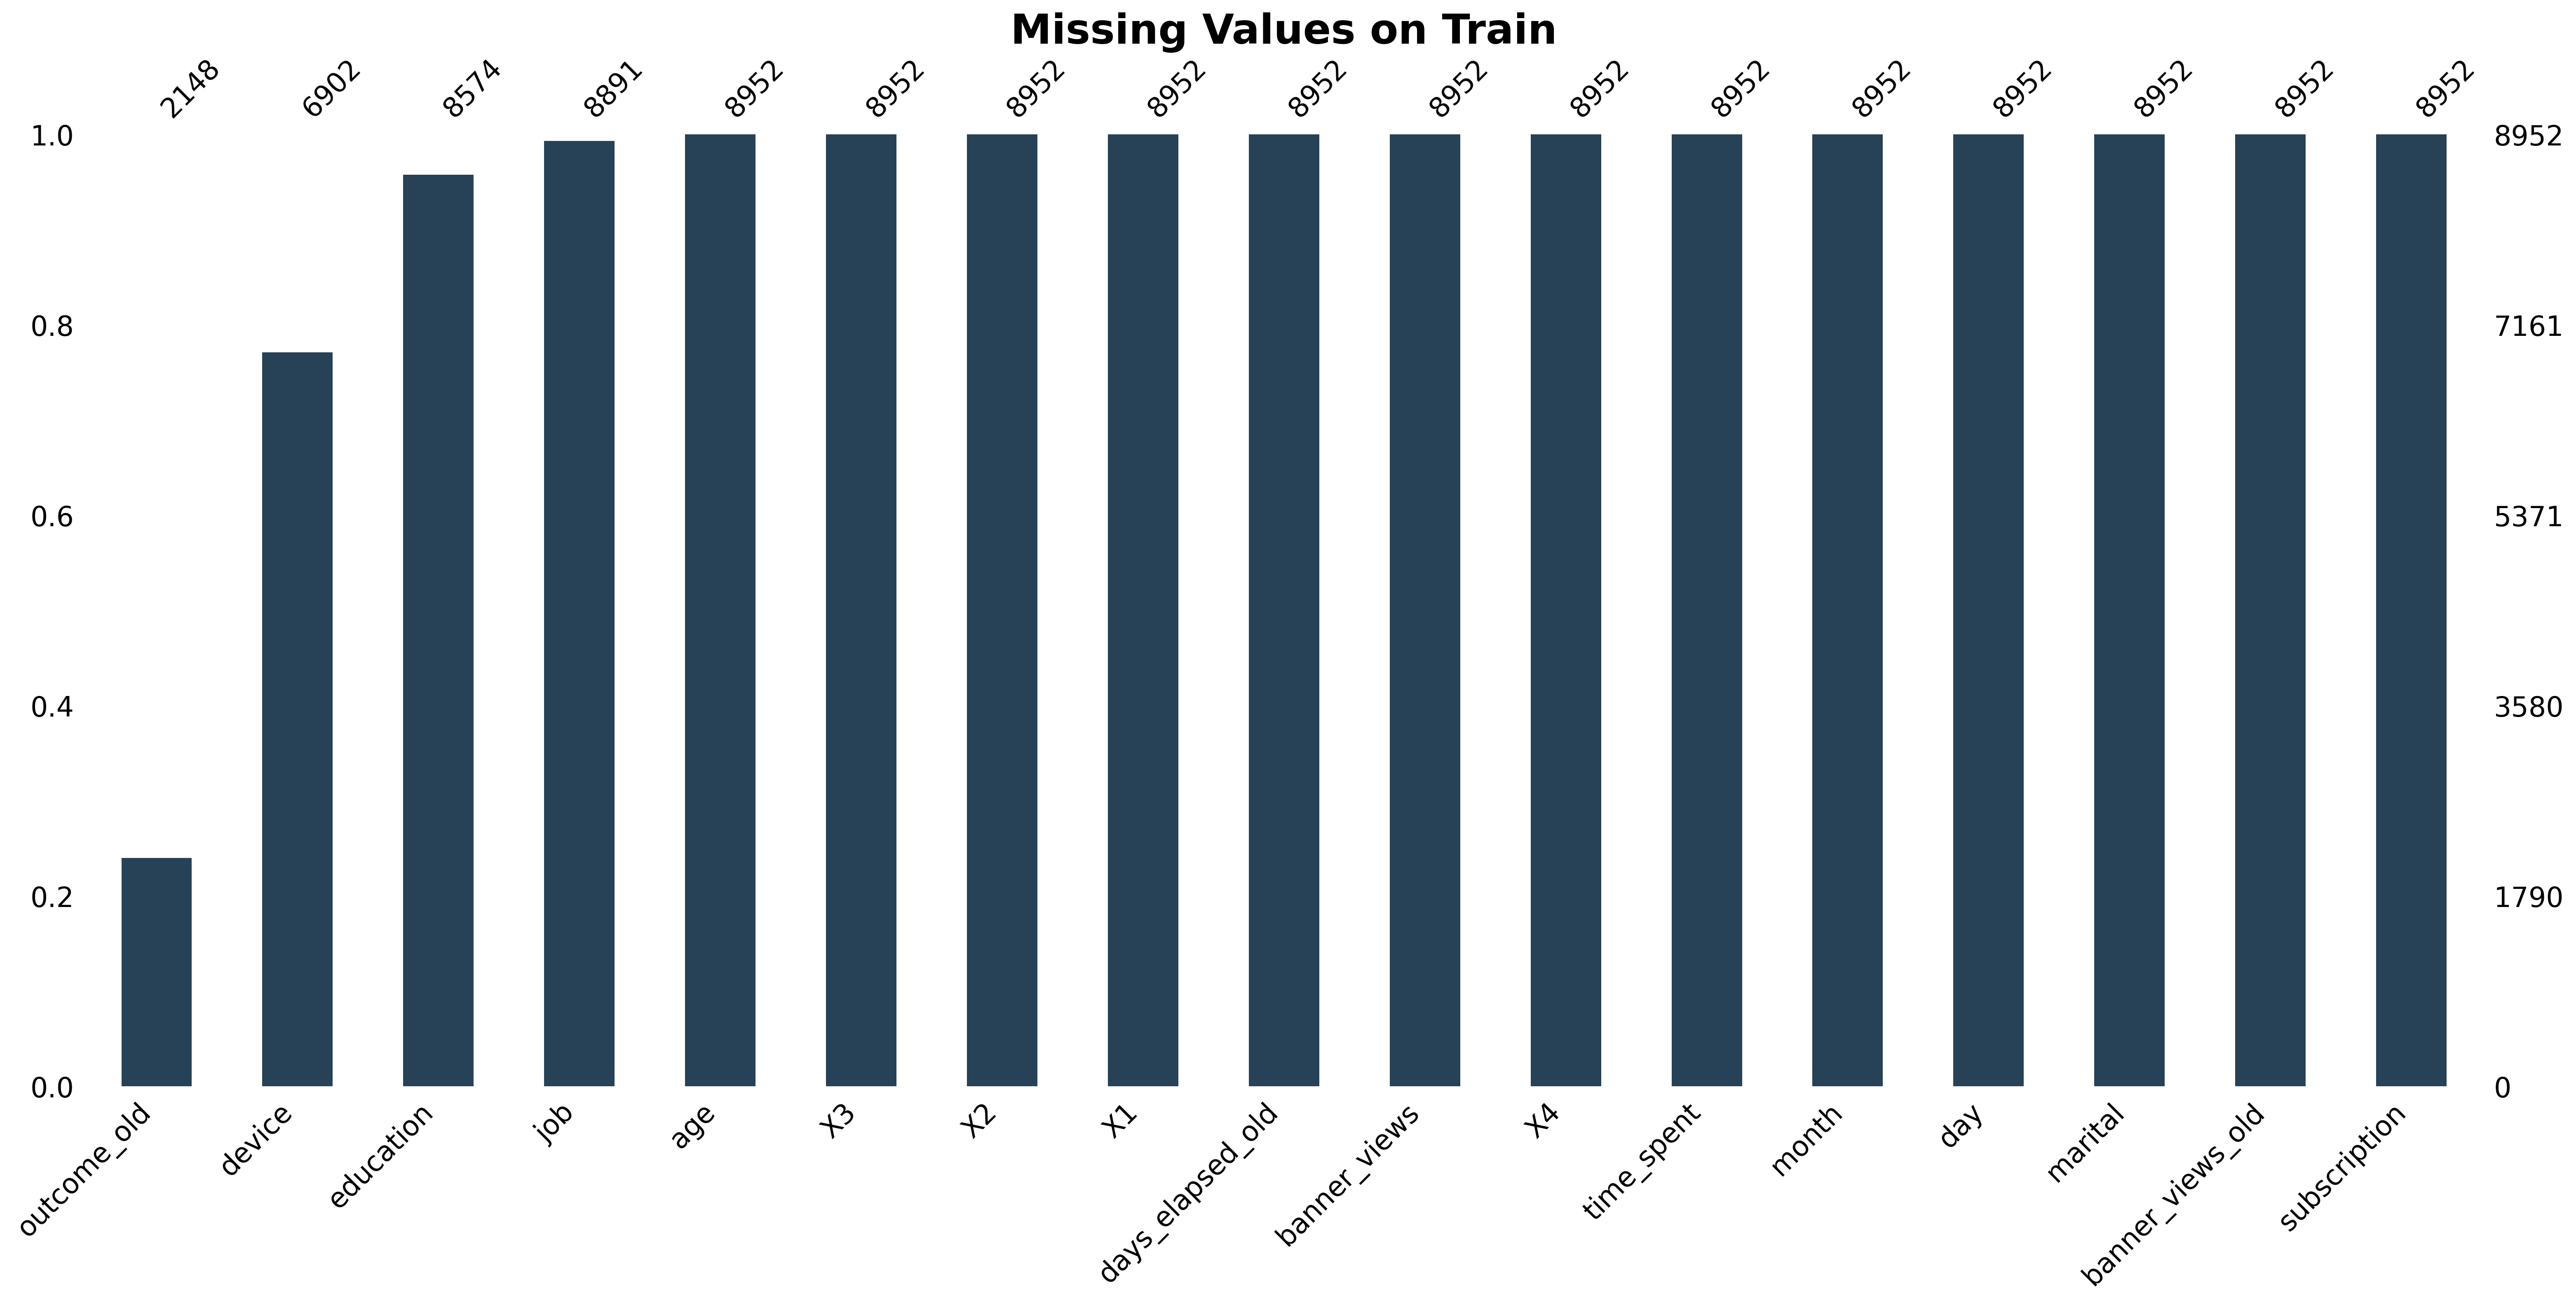

In [26]:
mpl.rcParams['figure.dpi']= 300

msno.bar(train,color=main_col, sort="ascending")
plt.title("Missing Values on Train", fontweight='bold', fontsize=24)

### Test

Here we see the missing values plot for the test data. 

Text(0.5, 1.0, 'Missing Values on Test')

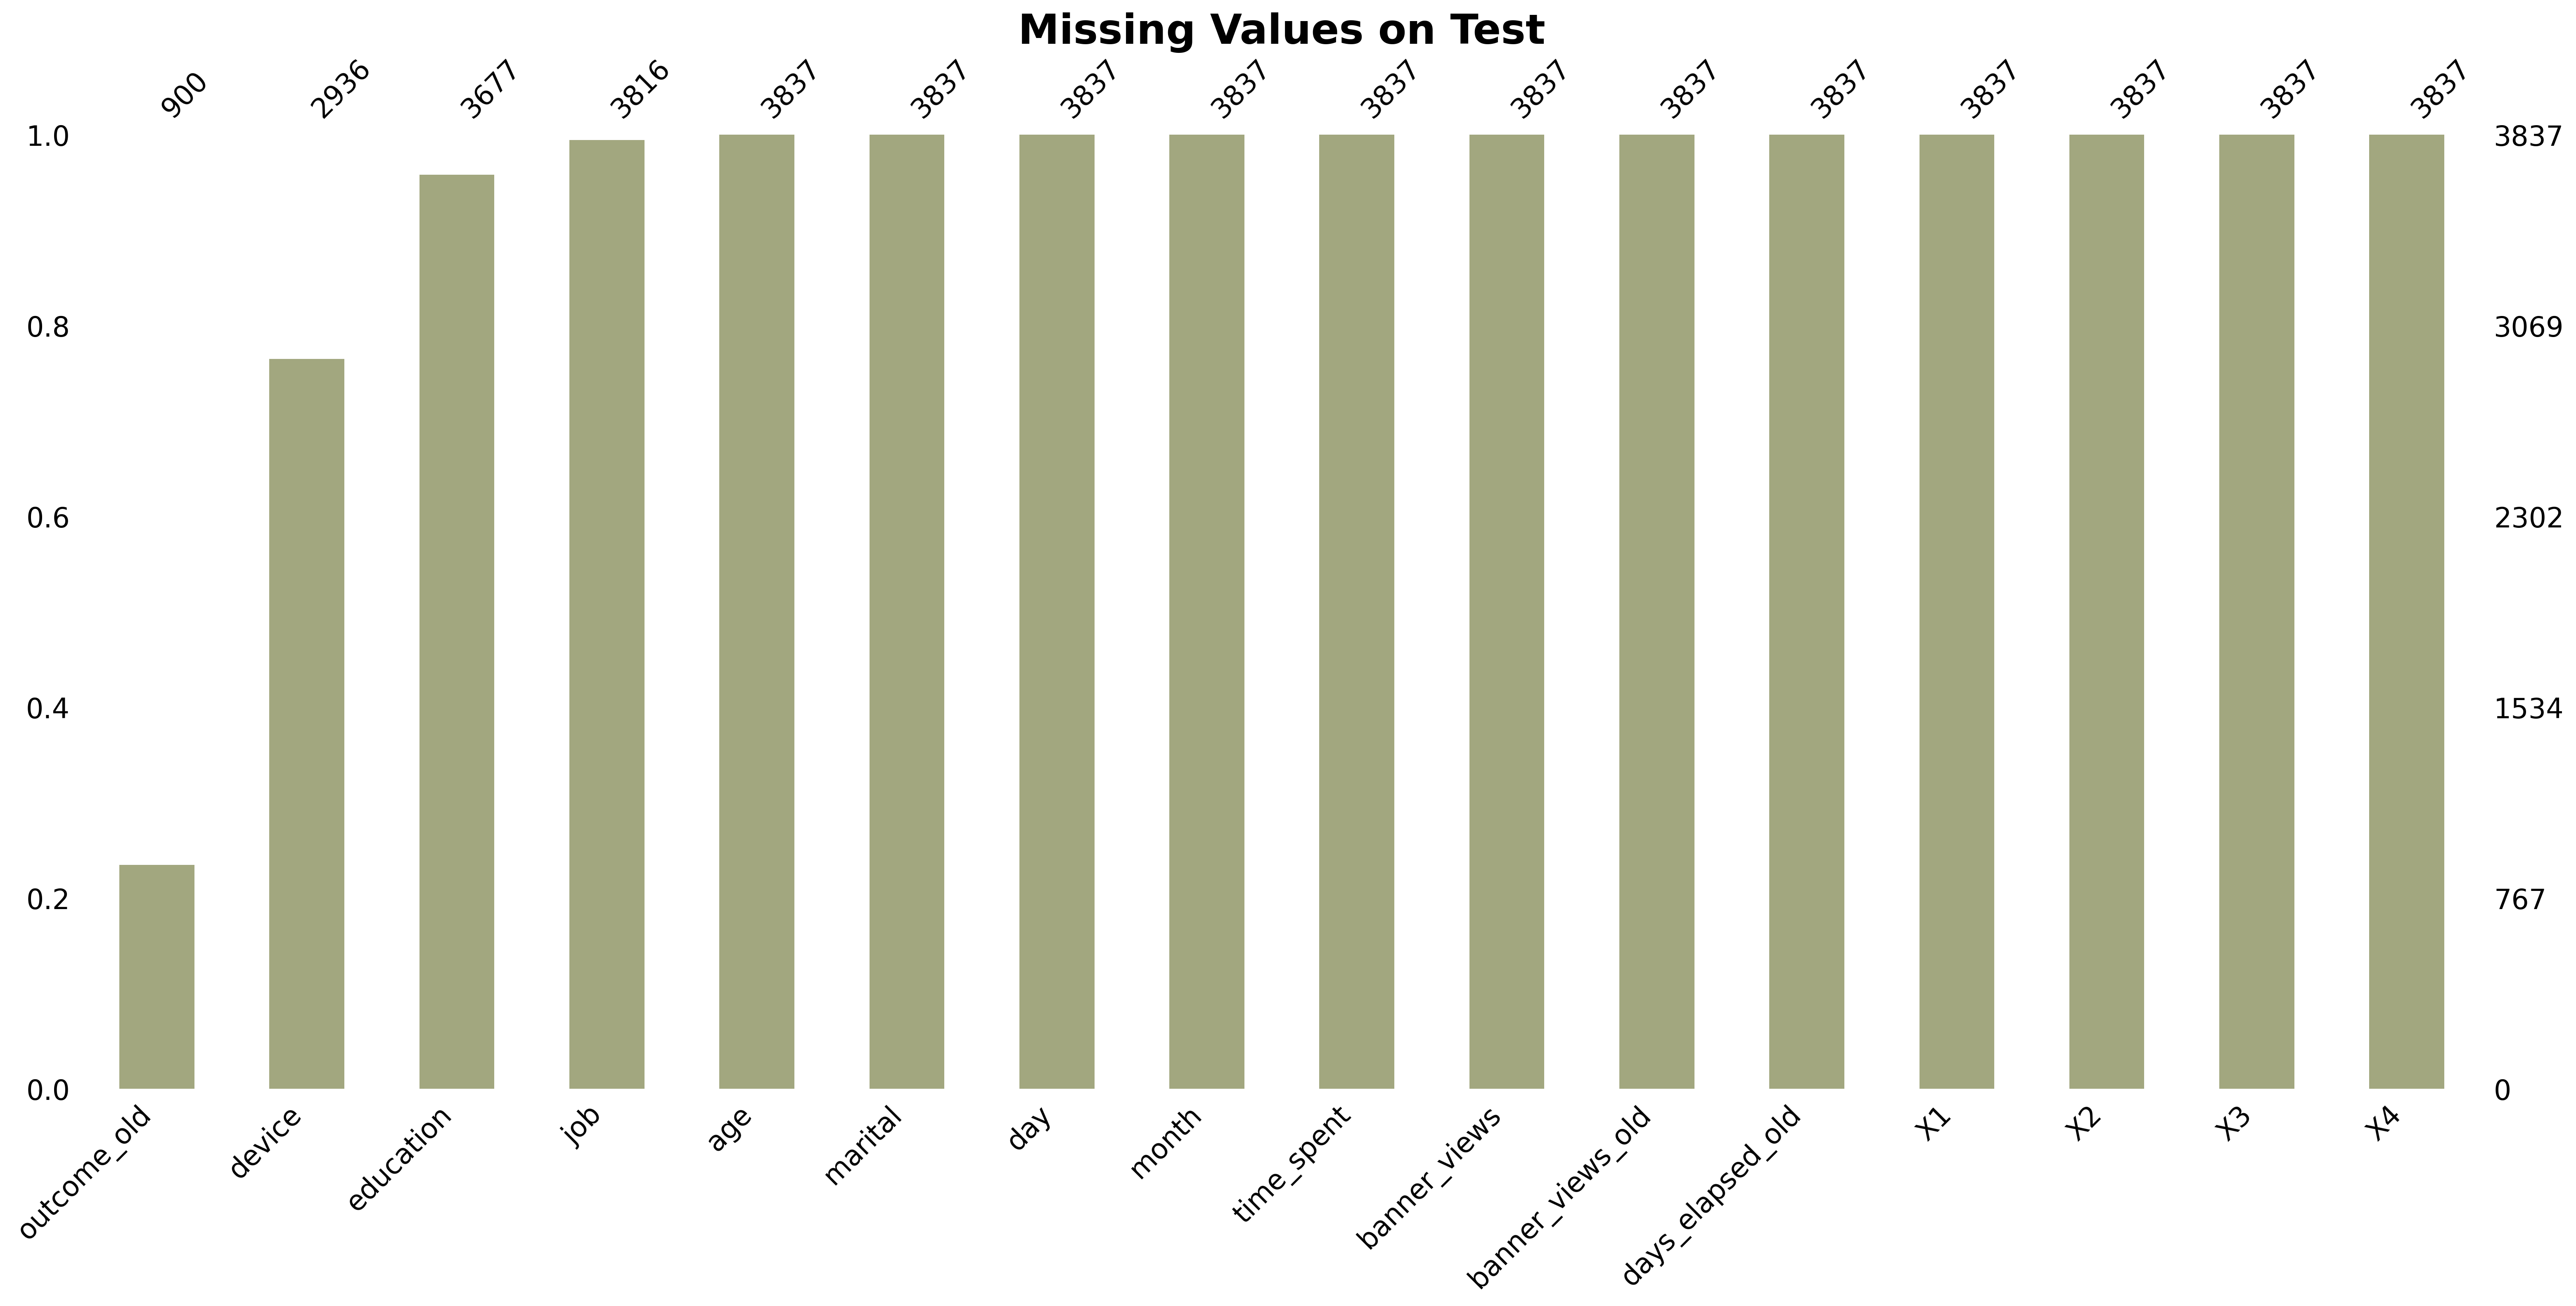

In [27]:
mpl.rcParams['figure.dpi']= 300

msno.bar(test,color=second_col, sort="ascending")
plt.title("Missing Values on Test", fontweight='bold', fontsize=24)

We better see that __outcome_old__ and __device__ are our main columns with missing values and that there are some in __education__ and __job__ (and __day_elapsed_old__ is -1 but still would count as a theorical missing)

## __Visualization__

Here look at the visualization of the training data. For numerical values we show a pairplot and for the categorical values a bar plot. In both plots we show the seperation of the data between subscribing and not subscribing. 

### Pairplot

Here we see the pairplot of the numerical values of the train data set. 

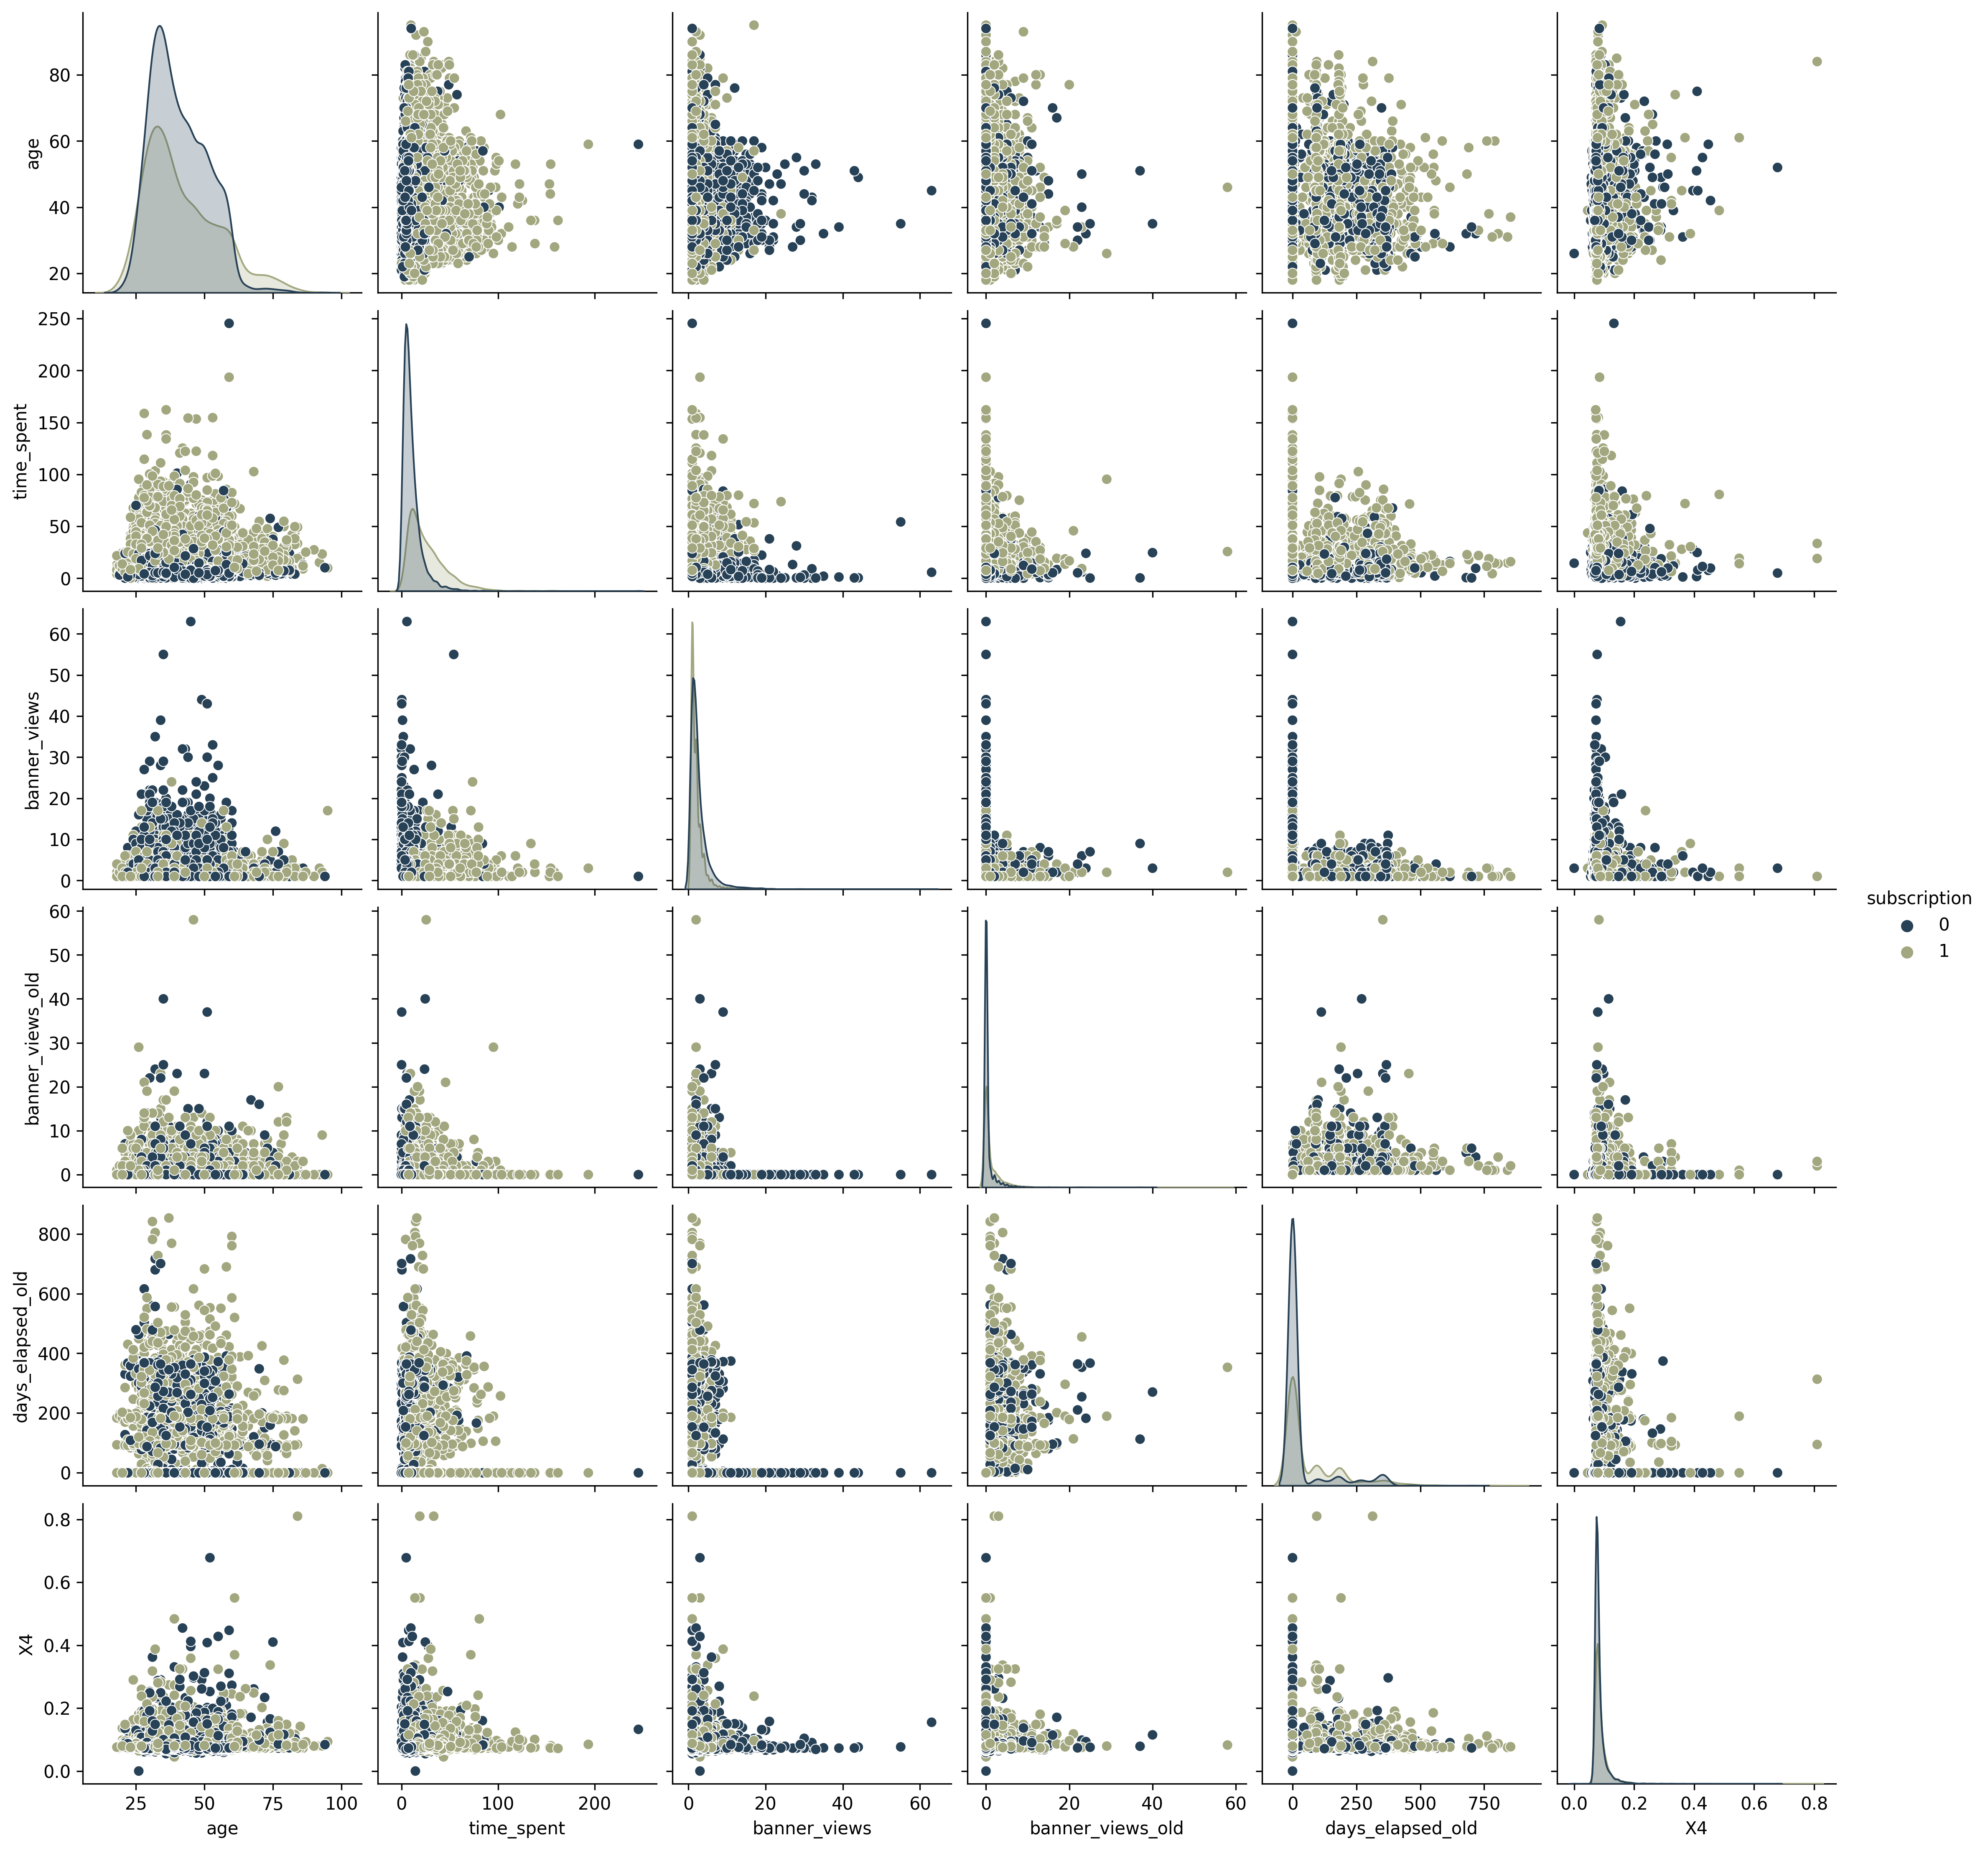

In [28]:
mpl.rcParams['figure.dpi']= 300

colors_subscription = [main_col, second_col]
sns.pairplot(train, hue = "subscription", palette=colors_subscription)

It can be observed that it is not possible to seperate the data according to subscription as there are no clear seperations between the classes when looking at the scatterplots. We also see that the data is highly right skewed for some variables. 

### Barplots

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000')])

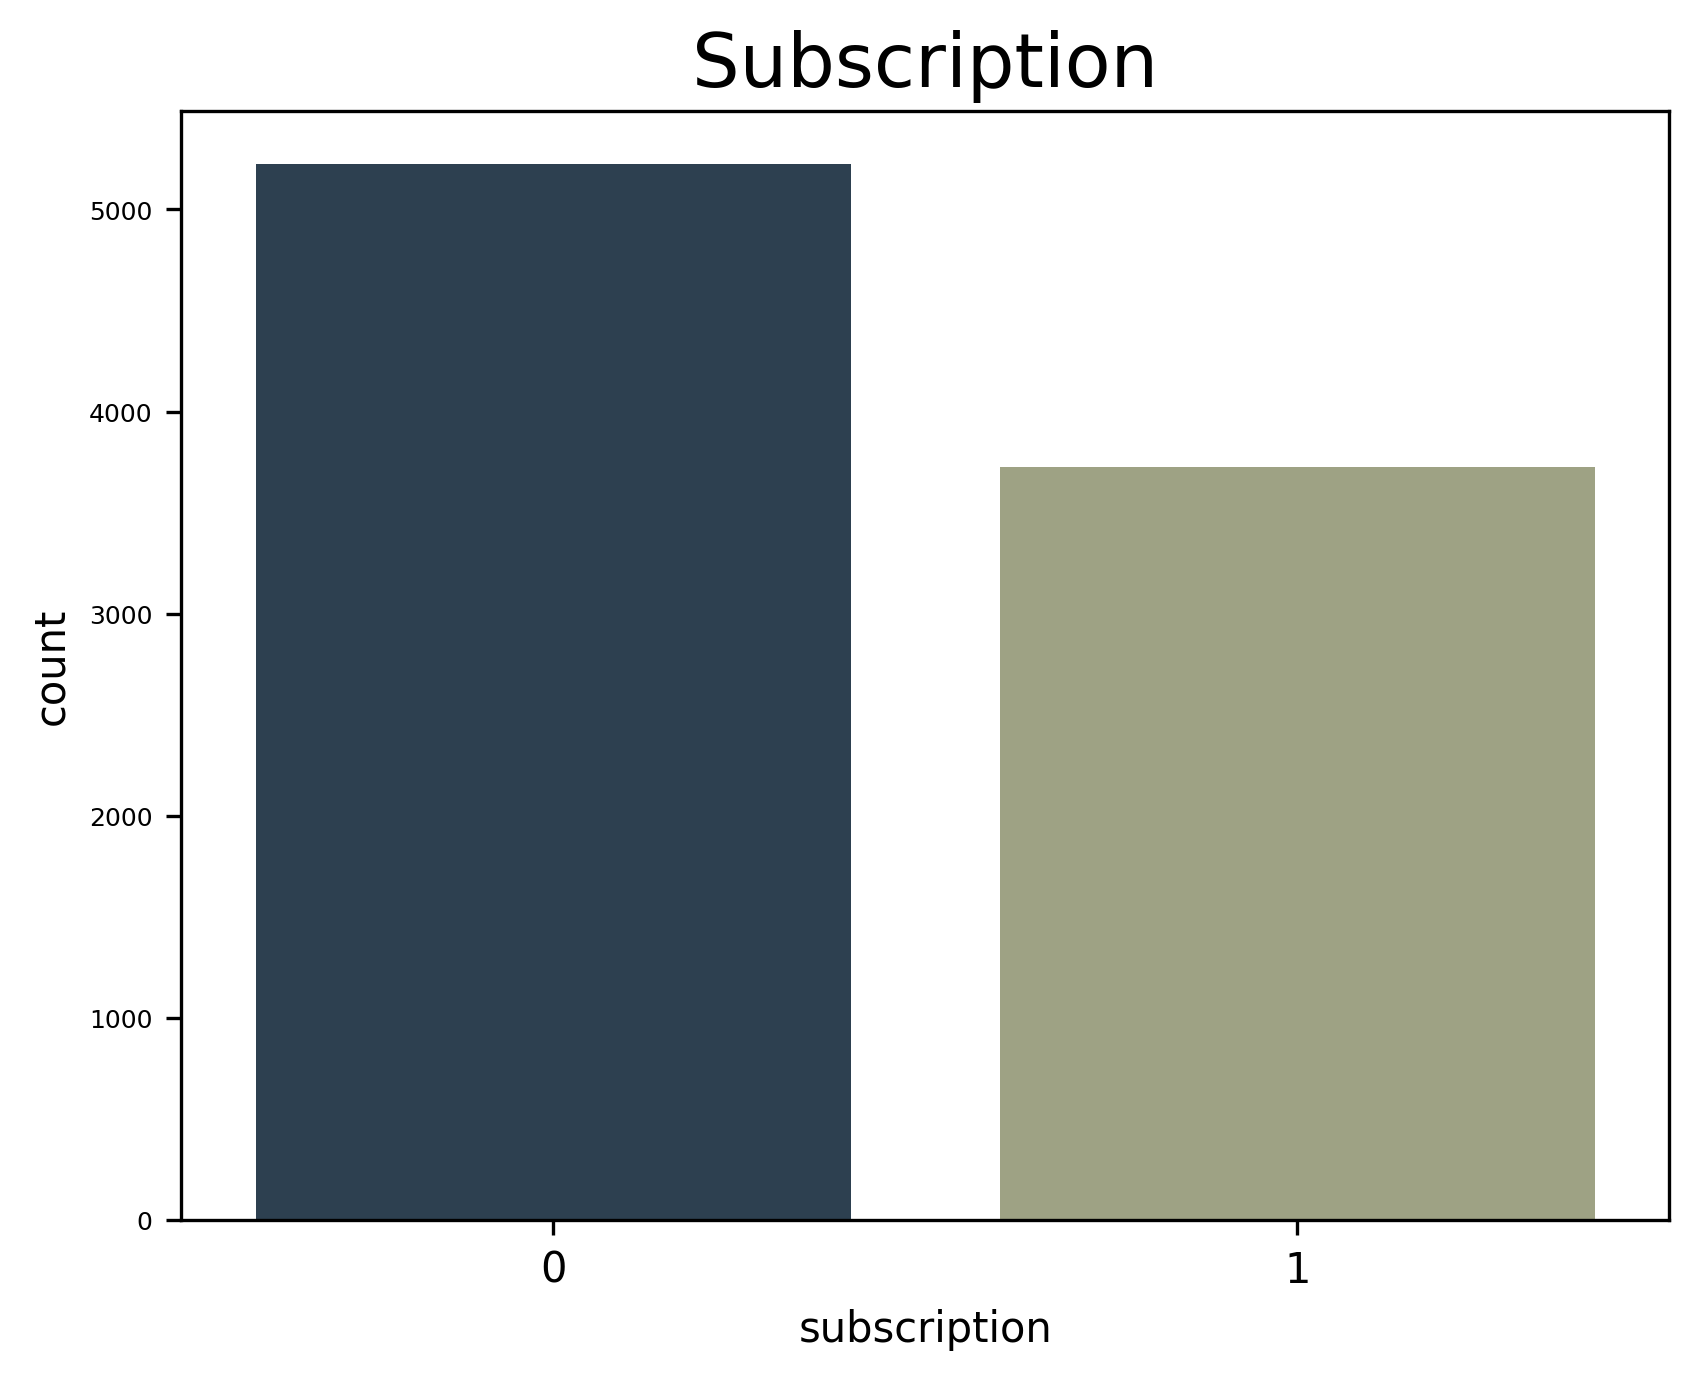

In [29]:
mpl.rcParams['figure.dpi']= 300

sns.countplot(x="subscription", data=train,palette= colors_subscription)

plt.title("Subscription", fontsize=18)
plt.yticks(fontsize=6)


From the barplot of the target variable it can be seen that we have more values for not subscribing than for subscribing. This can lead to some problems when fitting models as the accuracy increases when one predicts the zero class better than the one class as there are just more values to correctly classify. One could therefore think about undersampling or oversampling the data set such that there will be an equal amount of both values in the data set.  

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 1000.0, '1000'),
  Text(0, 1200.0, '1200'),
  Text(0, 1400.0, '1400')])

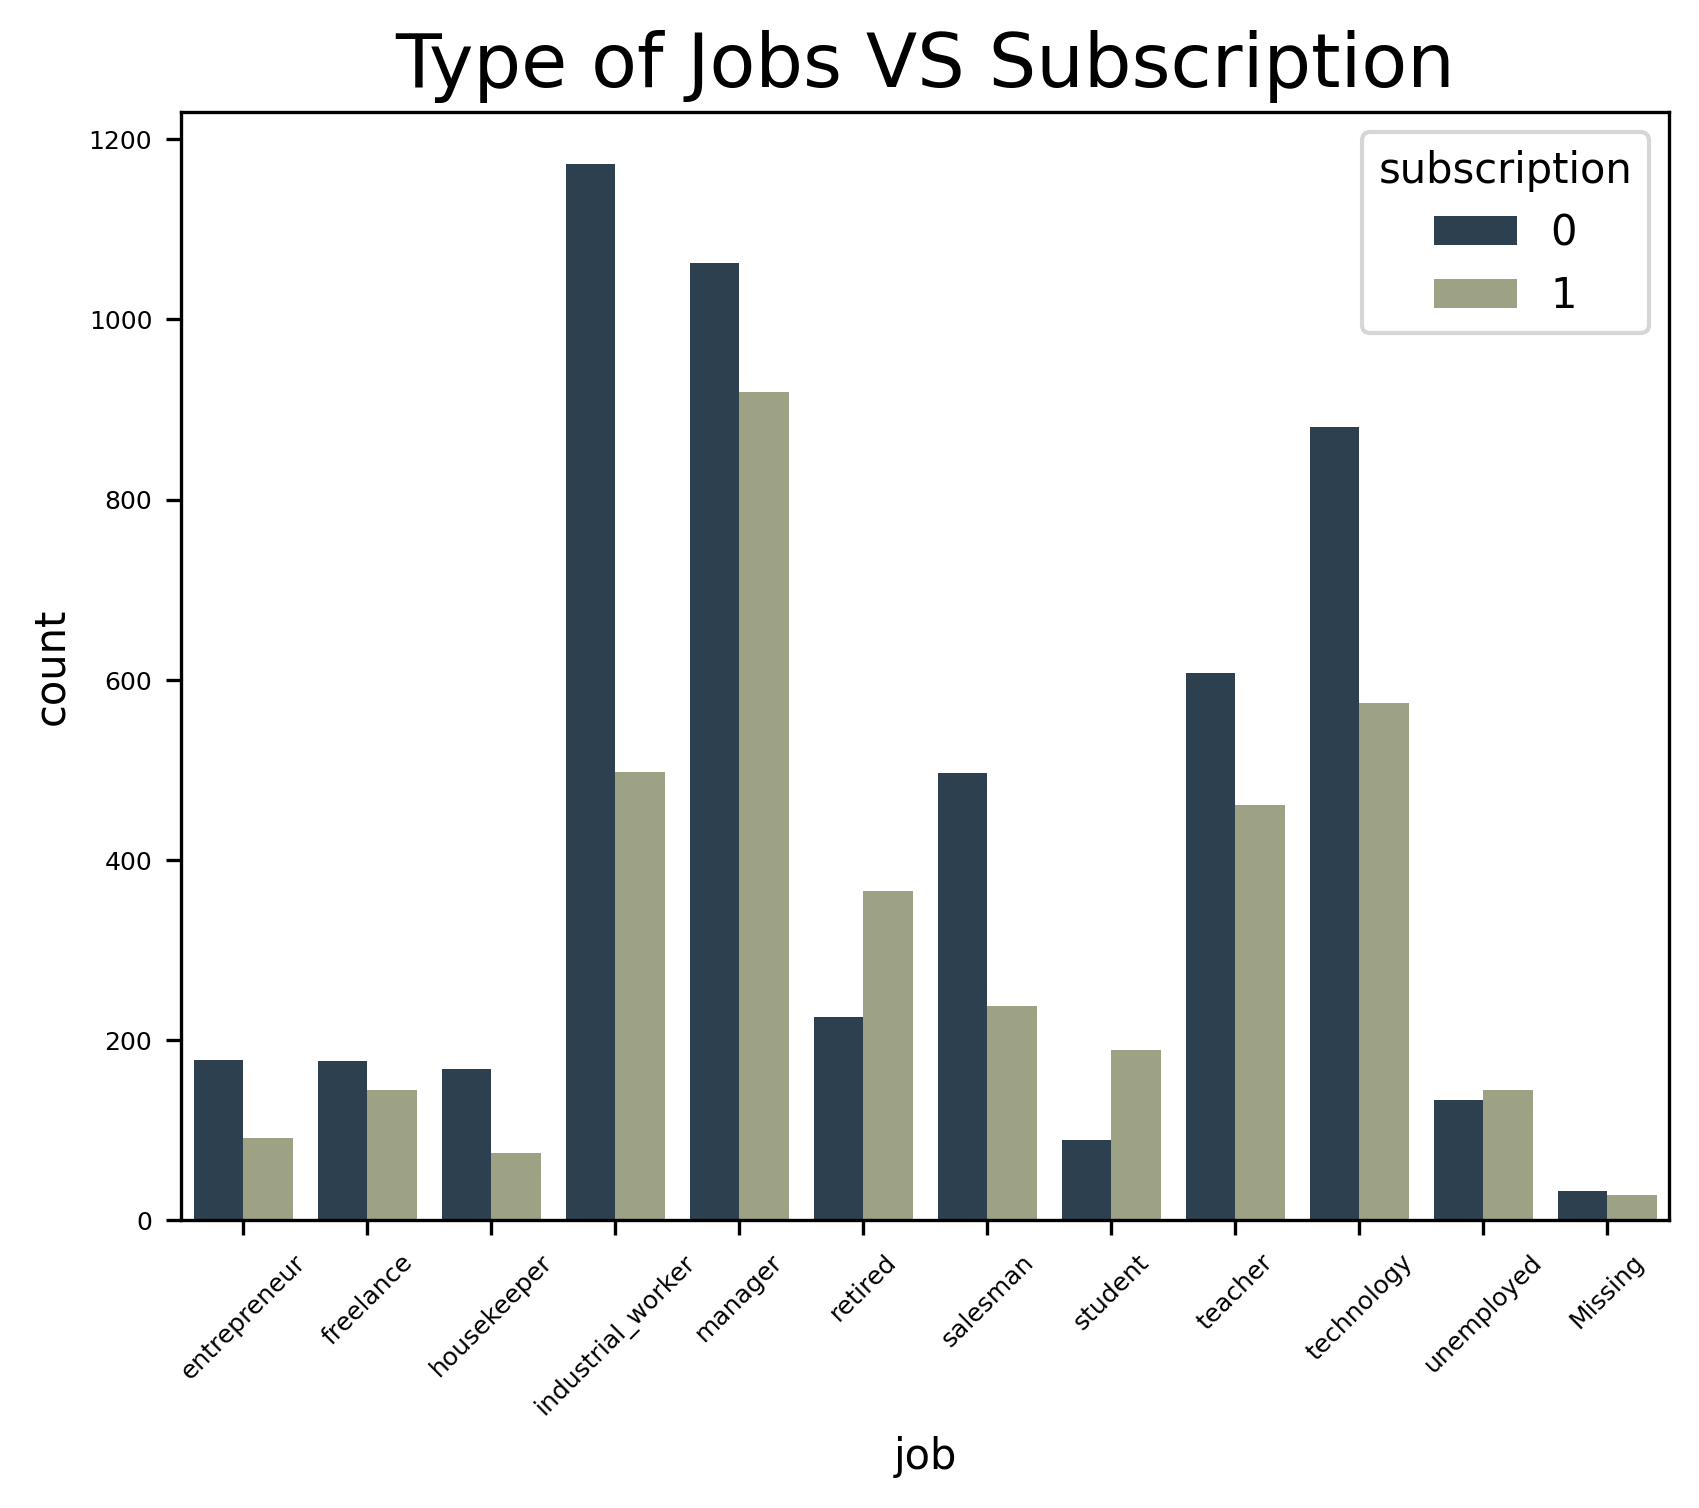

In [30]:

train_job = train.copy()
train_job.job = train_job.job.cat.add_categories("Missing").fillna("Missing")
sns.countplot(x="job", hue="subscription", data=train_job, palette=colors_subscription)

plt.xticks(rotation=45)
plt.title("Type of Jobs VS Subscription", fontsize=18)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

For most occurences in the job column it seems that more people are not subscribed than subscribed except for the retired and student occurence where the subscribers outweigh the non-subscribers. 

In [ ]:
train_device = train.copy()
train_device.device = train_device.device.cat.add_categories("Missing").fillna("Missing")
train_edu = train.copy()
train_edu.education = train_edu.education.cat.add_categories("Missing").fillna("Missing")

f, axes = plt.subplots(1, 3)

sns.countplot(x="marital", hue="subscription", data=train, palette=colors_subscription, ax=axes[0])
sns.countplot(x="education", hue="subscription", data=train_edu, palette=colors_subscription, ax=axes[1])
sns.countplot(x="device", hue="subscription", data=train_device, palette=colors_subscription, ax=axes[2])

# tilt ticks and set size
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Set the title for the figure
plt.suptitle("Marital staus, Education and Device VS Subscription ", fontsize=20)

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(12, 8)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the combined bar plots
plt.show()

In all of the shown columns we can see that it is really hard to seperate the values just based on one category. 

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000')])

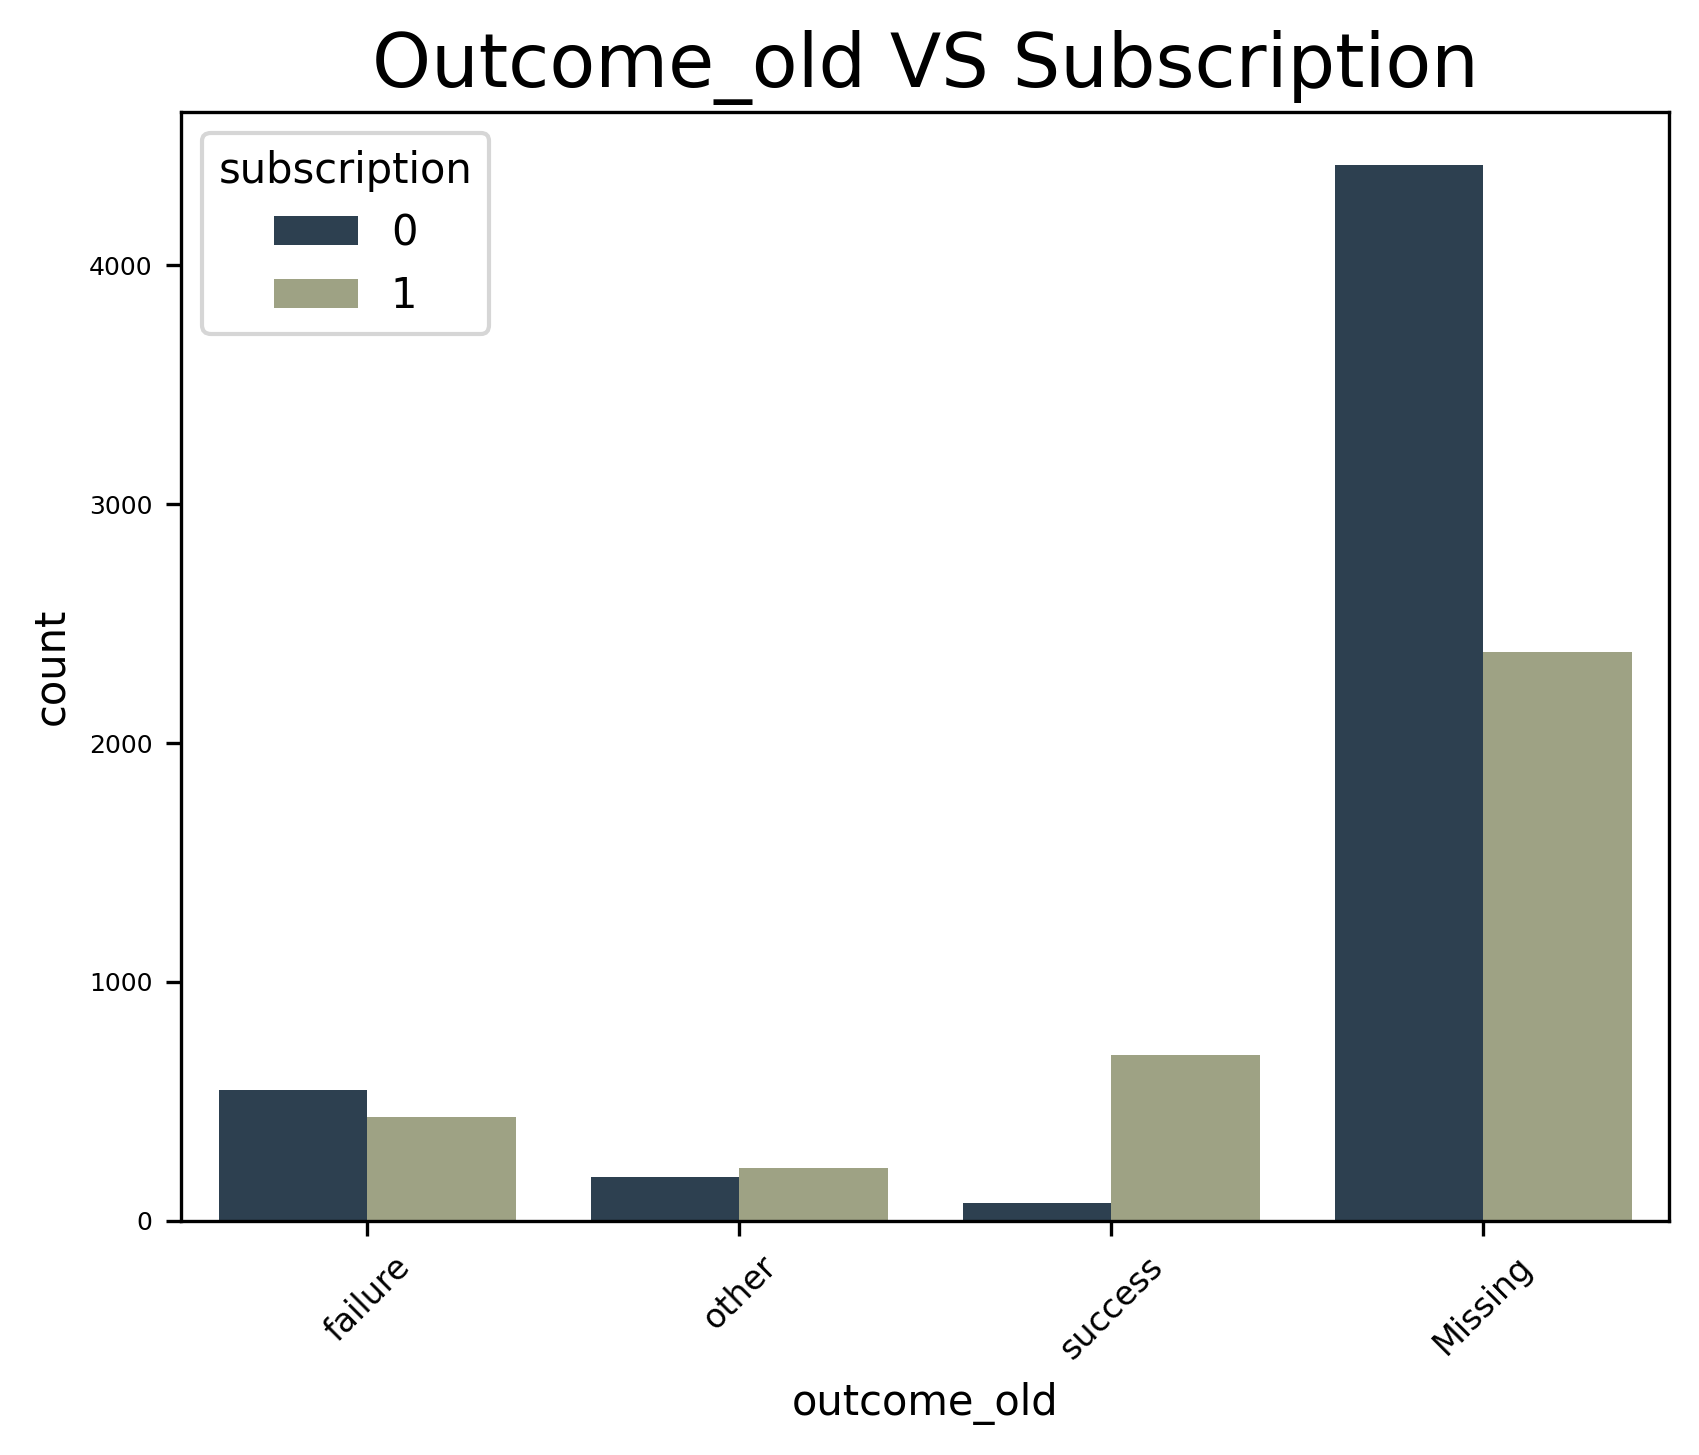

In [34]:
train_oo = train.copy()
train_oo.outcome_old = train_oo.outcome_old.cat.add_categories("Missing").fillna("Missing")

sns.countplot(x="outcome_old", hue="subscription", data=train_oo, palette=colors_subscription)

plt.xticks(rotation=45)
plt.title("Outcome_old VS Subscription", fontsize=18)

plt.xticks(fontsize=8)
plt.yticks(fontsize=6)

It seems that one can predict the class well when the outcome_old is successful. This makes sense as someone who already has seen an old banner is probably subscribed. But at the same time there are a lot of missing values in this column which makes it hard to use in building models. 

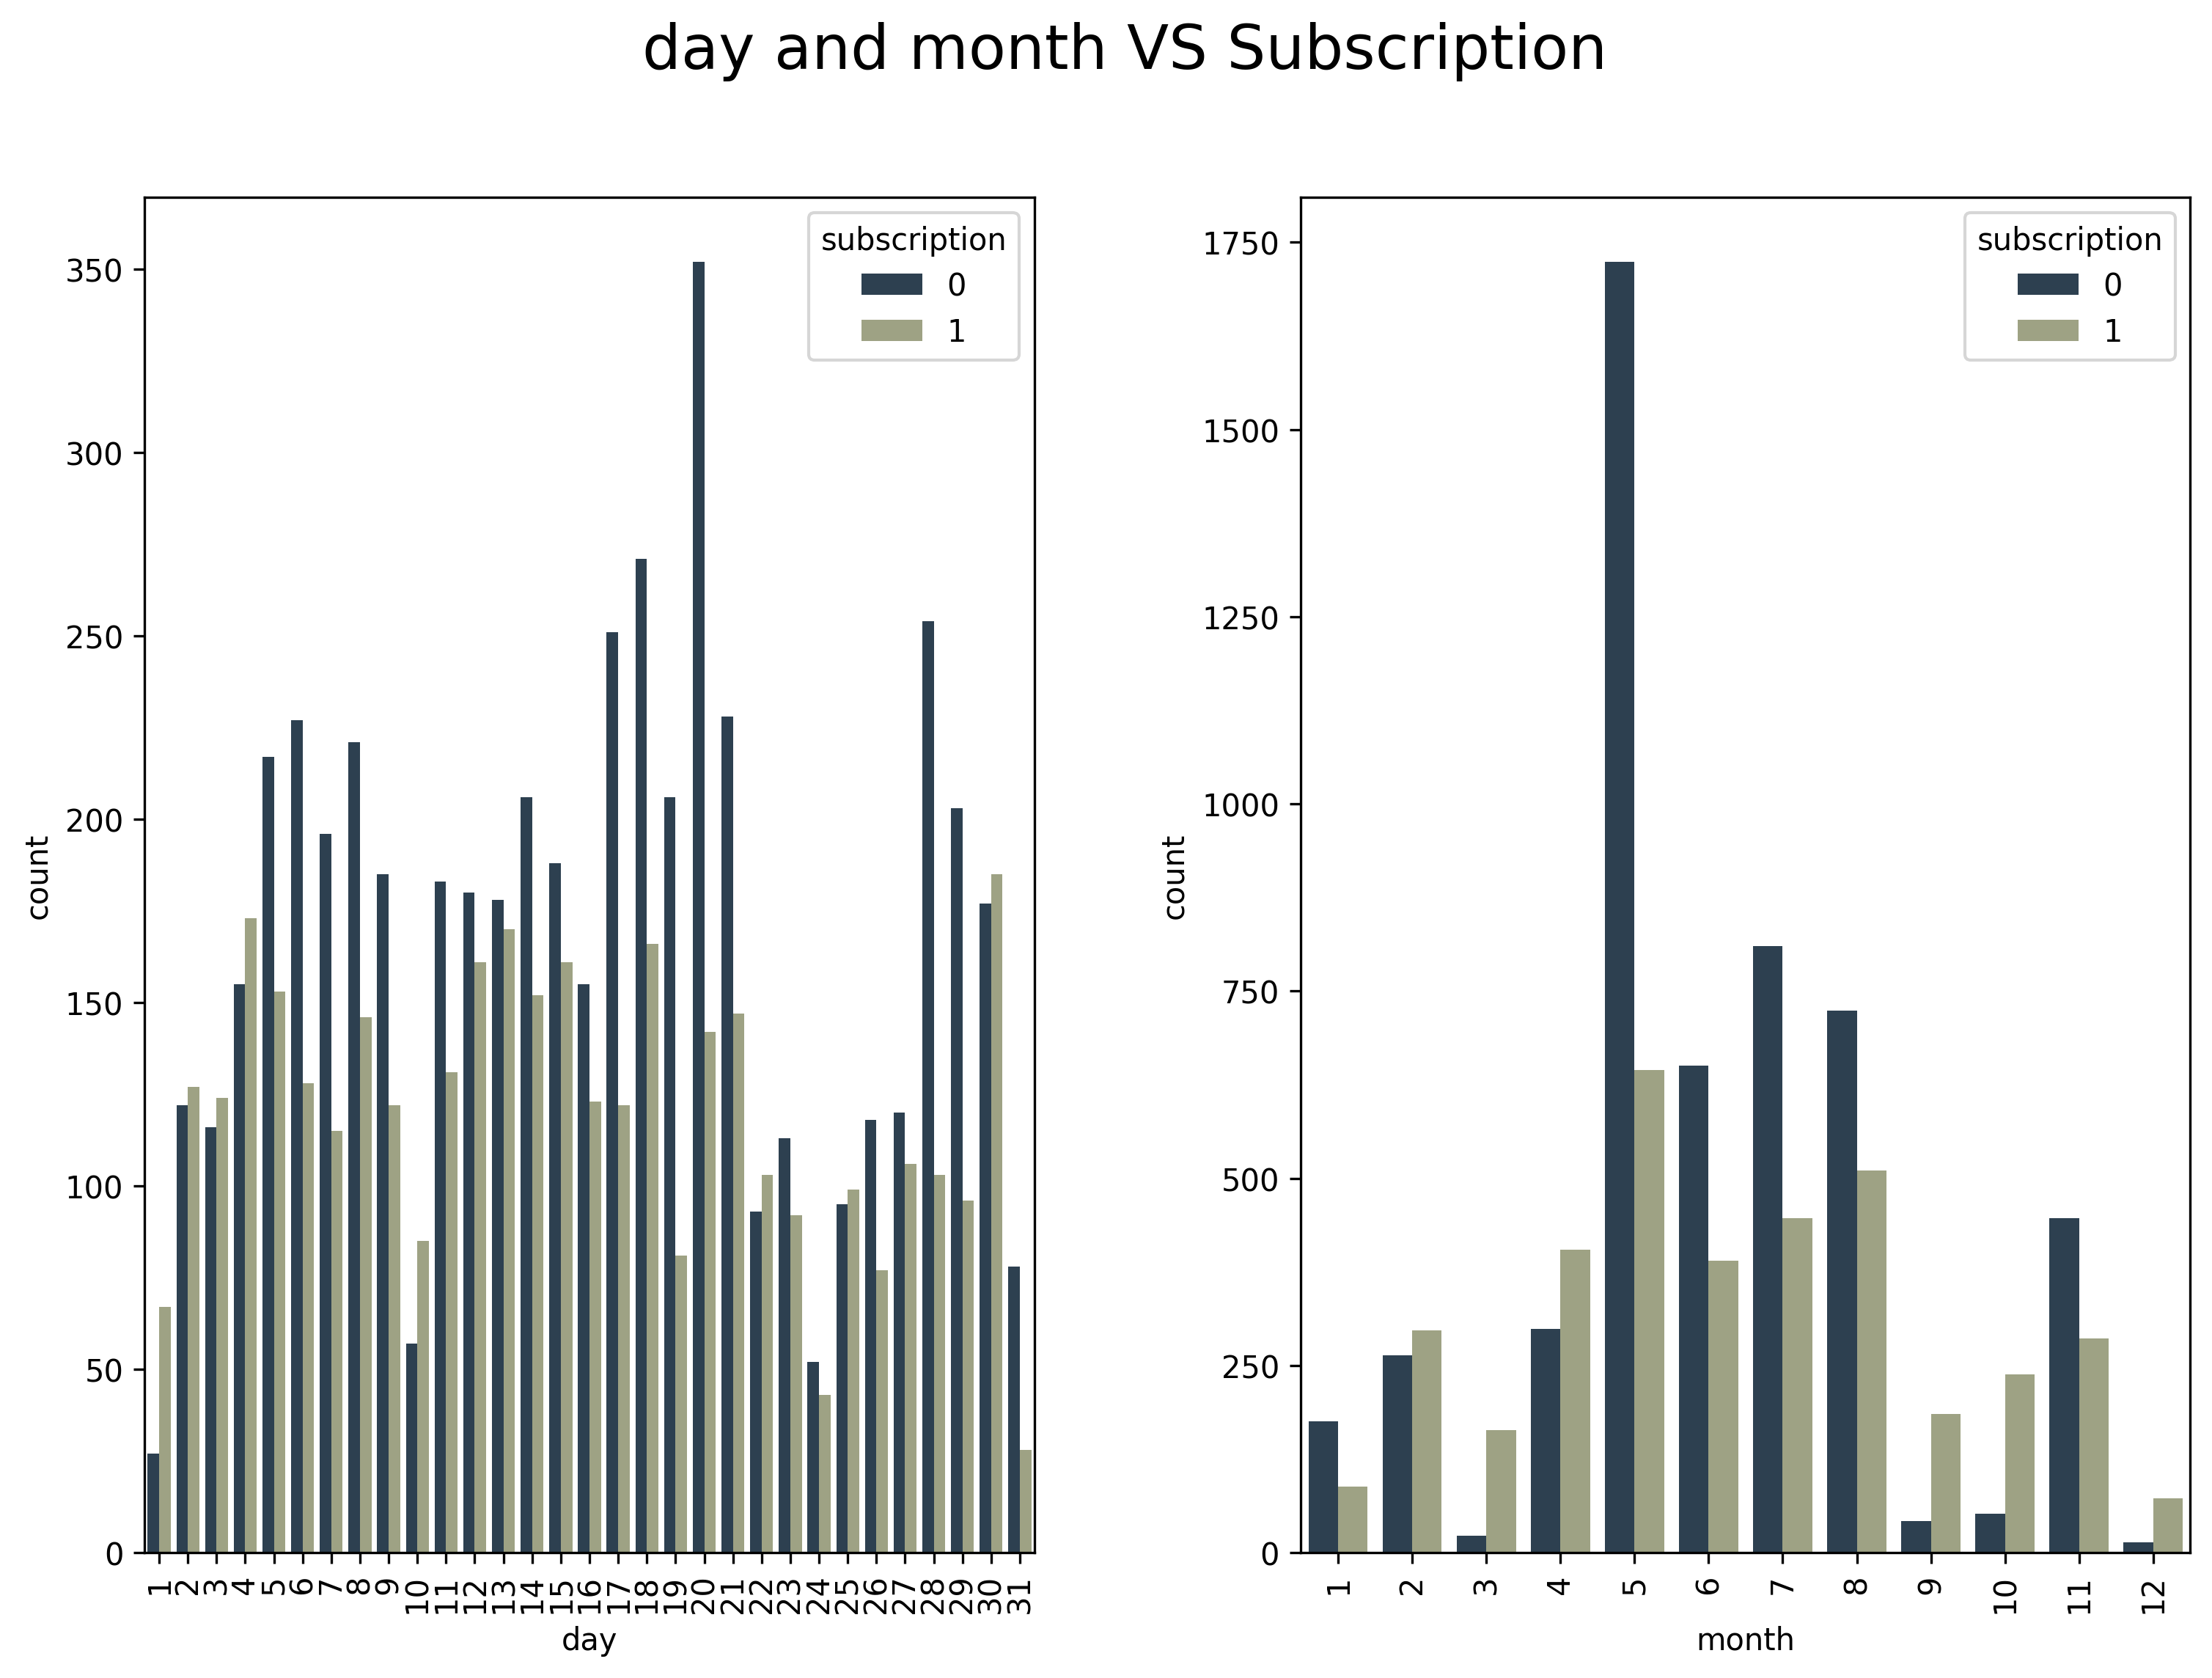

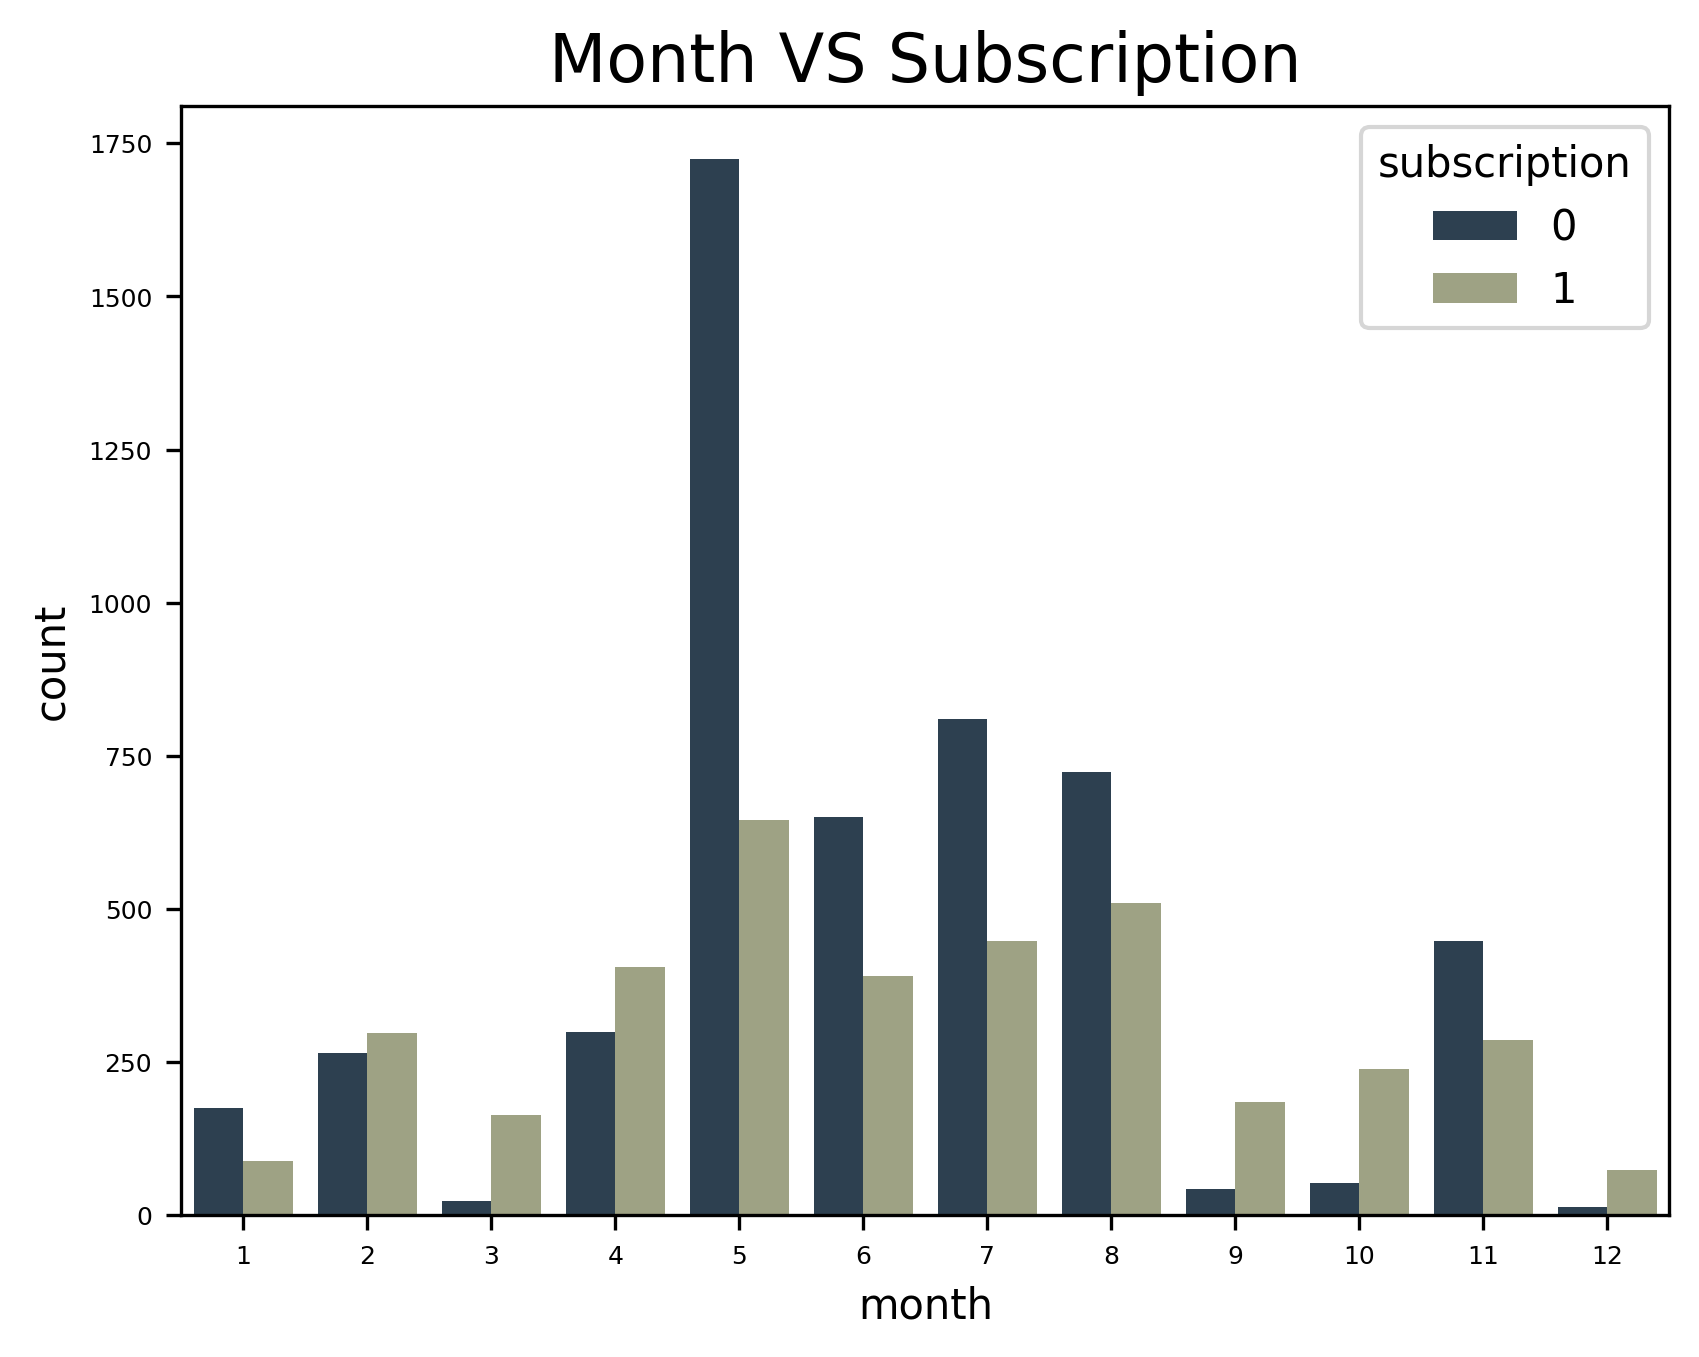

In [36]:
colors_subscription = [main_col, second_col]
f, axes = plt.subplots(1, 2)

sns.countplot(x="day", hue="subscription", data=train, palette=colors_subscription, ax=axes[0])
sns.countplot(x="month", hue="subscription", data=train, palette=colors_subscription, ax=axes[1])

# Set the title for the figure
plt.suptitle("day and month VS Subscription ", fontsize=20)

# tilt ticks and set size
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(12, 8)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the combined bar plots
plt.show()

From both the day and the month we do not see one occurence which seperates the data well. This would also have been worrying as subcriptions should be unconected to the date. 

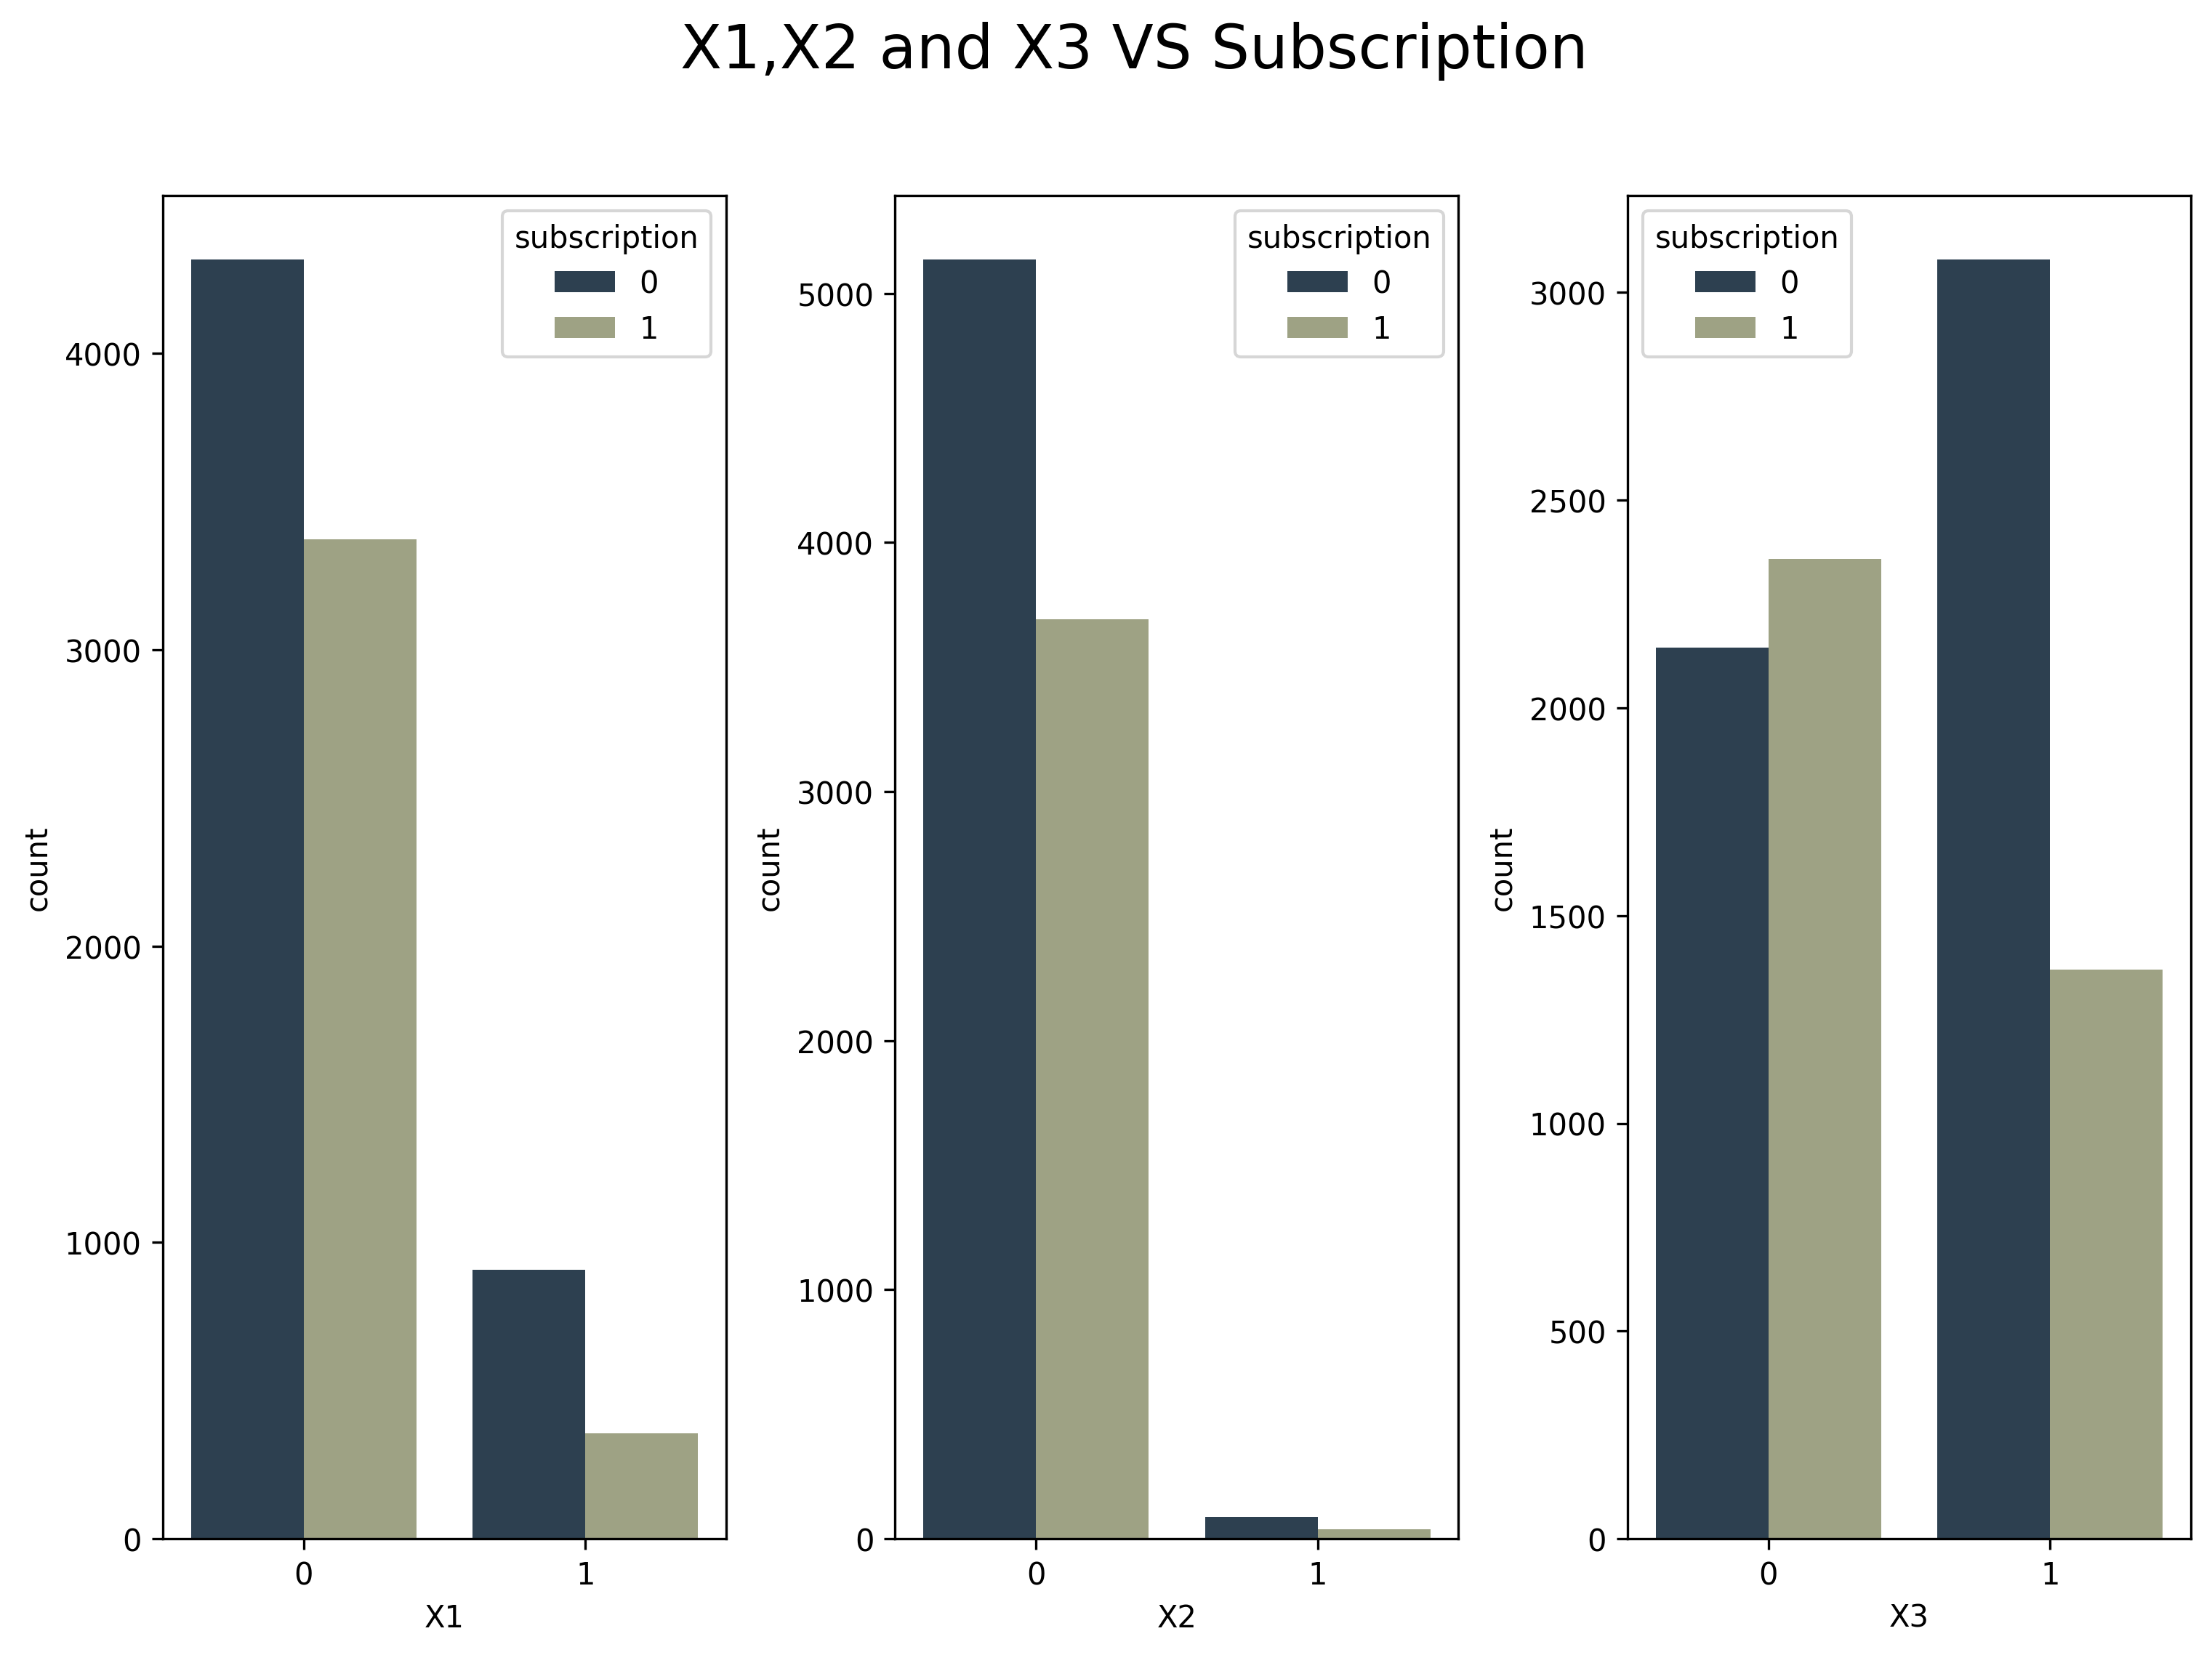

In [37]:
f, axes = plt.subplots(1, 3)

sns.countplot(x="X1", hue="subscription", data=train, palette=colors_subscription, ax=axes[0])
sns.countplot(x="X2", hue="subscription", data=train, palette=colors_subscription, ax=axes[1])
sns.countplot(x="X3", hue="subscription", data=train, palette=colors_subscription, ax=axes[2])

# Set the title for the figure
plt.suptitle("X1,X2 and X3 VS Subscription ", fontsize=20)

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(12, 8)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the combined bar plots
plt.show()

From all of the plots it can be seen that also for the categorical variables it is not possible to perfectly seperate the subscription by just using one variable. One can think about dropping X2 as most of the data is in one category anyways and thereby the column doesn't provide a lot of information. 

## __Correlation Map__

Here we show the correlation map of the numerical predictors. 

C:\Users\Manu\AppData\Local\Temp\ipykernel_8796\1257374829.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


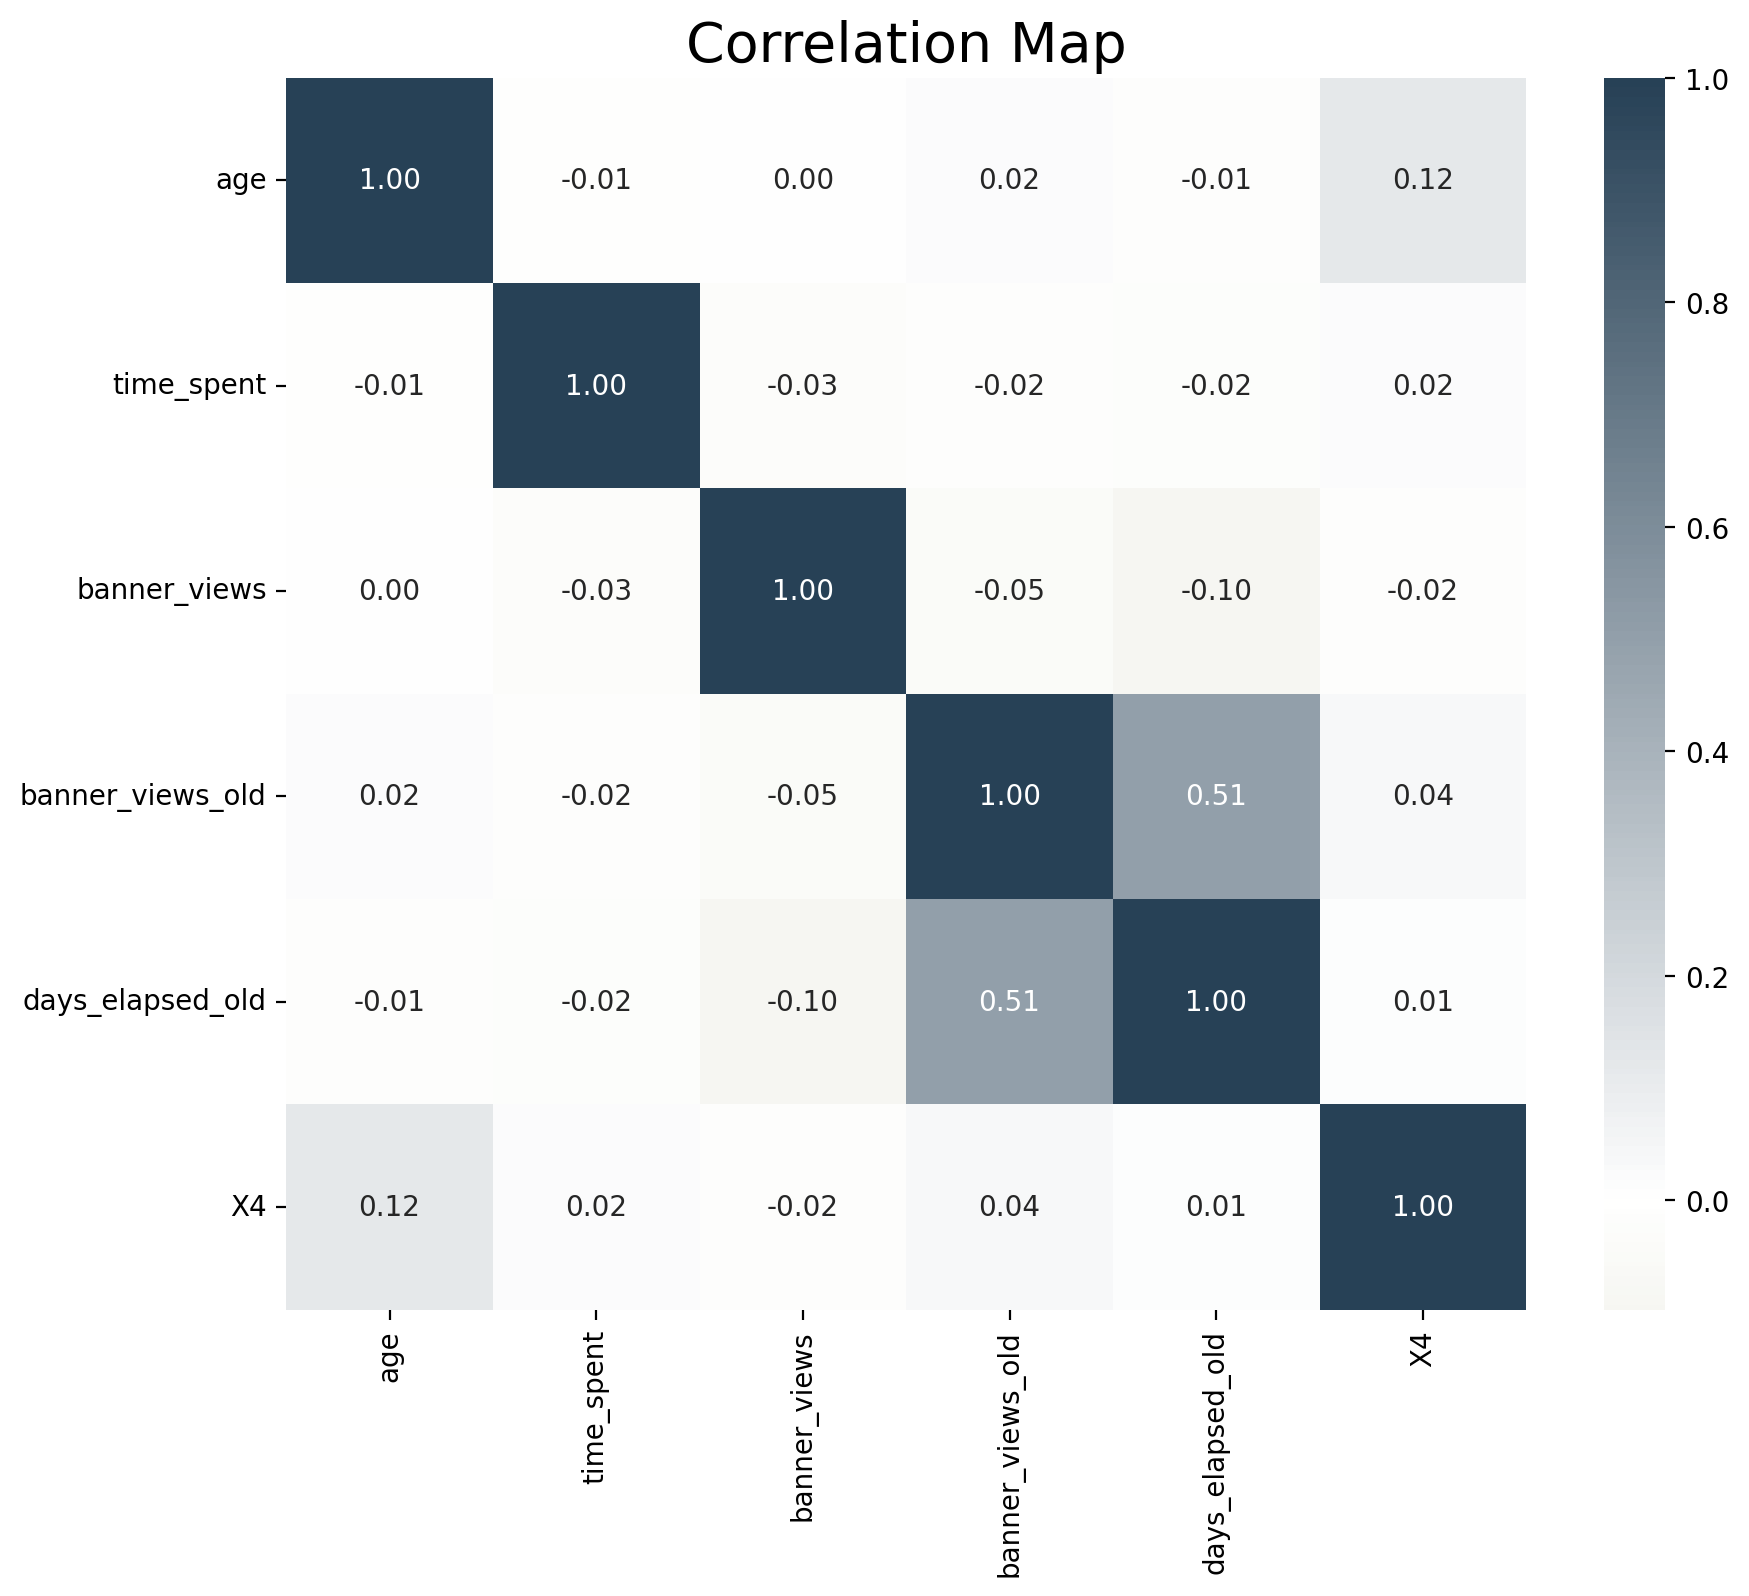

In [38]:
mpl.rcParams['figure.dpi']= 200

custom_cmap = mcolors.LinearSegmentedColormap.from_list("", [second_col, "white", main_col])

# Calculate the correlation matrix using pandas
corr_matrix = train.corr()

# Create a figure with a specific size using plt.subplots()
fig, ax = plt.subplots(figsize=(10, 8))

# Create a heatmap of the correlation matrix using sns.heatmap()
sns.heatmap(corr_matrix, annot=True, cmap=custom_cmap, fmt='.2f', center=0)

# Add a title to the plot
ax.set_title("Correlation Map", fontsize=20)

# Show the plot
plt.show()

There is one correlation of 0.51 between banner_views_old and days_elasped_old but we don't have strong __correlations__ among our set of numeric variables, as they are either under 0.7 or above -0.7. Therefore there is no risk of __multicolinearity__. 

# __Feature Engineering__

Here we will show the feature engineering that was done to the variables. 

## __Undersampling__

DONT RUN THIS -> NOT IMPROVING

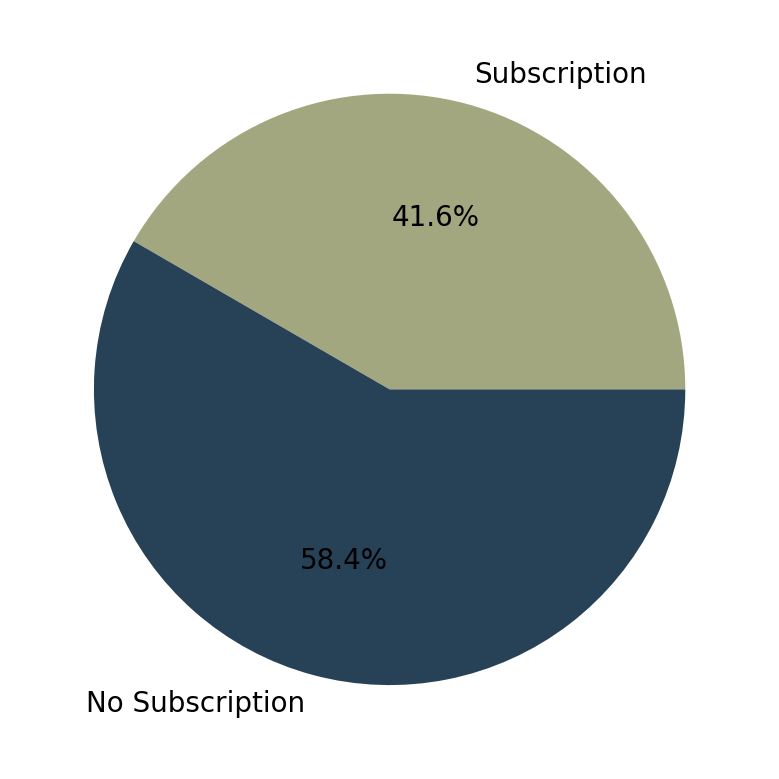

In [39]:
# calculate the proportion of each class in the 'score' column
proportions = train['subscription'].value_counts(normalize=True)

#print("\nProportions between Training and Validation:","\n Training: ", round(PropTR,2),"%", "\n Validation: ",round(PropTV,2),"%")

mpl.rcParams['figure.dpi']= 200

mylabels = ["Subscription","No Subscription"]

y = np.array([proportions[1],proportions[0]])

piecolors = [second_col,main_col]

plt.pie(y, labels = mylabels, colors = piecolors, autopct='%1.1f%%')
plt.show() 

We have a slight imbalance in the subscriptions in our dataset, that may lead to future issues when our models are trained and the test data from kaggle doesn't have such imbalances, or even worst balances such as more subscription than no subscription, our models would then be underperforming in positive class. We can use Undersampling since we have already a lot of observations.

In [40]:
from sklearn.utils import resample

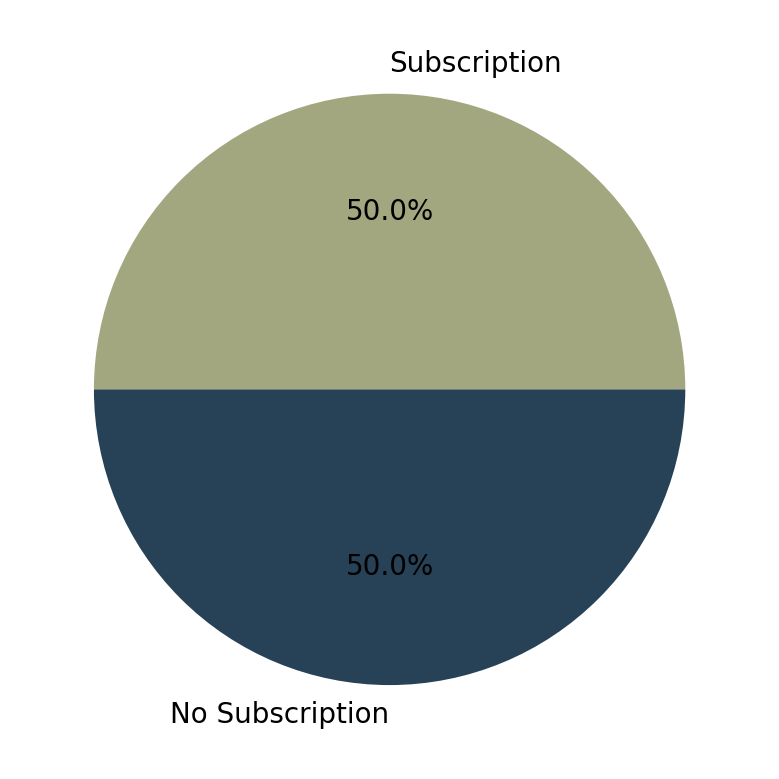

In [41]:
df = train.copy()

# separate the majority and minority classes
df_majority = df[df.subscription==0]
df_minority = df[df.subscription==1]

# downsample the majority class to have the same number of rows as the minority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

# combine the minority class and the downsampled majority class
df_downsampled =pd.concat([df_minority, df_majority_downsampled])

# sort the dataframe by the id column
df_downsampled = df_downsampled.sort_values('Id')

train = df_downsampled.copy()

# calculate the proportion of each class in the 'score' column
proportions = train['subscription'].value_counts(normalize=True)

#print("\nProportions between Training and Validation:","\n Training: ", round(PropTR,2),"%", "\n Validation: ",round(PropTV,2),"%")

mpl.rcParams['figure.dpi']= 200

mylabels = ["Subscription","No Subscription"]

y = np.array([proportions[1],proportions[0]])

piecolors = [second_col,main_col]

plt.pie(y, labels = mylabels, colors = piecolors, autopct='%1.1f%%')
plt.show() 

Now, we have the same proportion of subscriptions outcomes

## __Scaling__

We scaled the data such that they are distrubted around a mean of 0 and with a standard deviation of 1. 

In [42]:
train_num = train[train_numeric]
train_cat = train[train_categorical]

test_num = test[test_numeric]
test_cat = test[test_categorical]

# create a StandardScaler object
scaler = StandardScaler()

# fit and transform the scaler on the numerical variables
scaler.fit(train_num)
train_num = pd.DataFrame(scaler.transform(train_num), columns=train_num.columns, index=train_num.index)
test_num = pd.DataFrame(scaler.transform(test_num),columns=test_num.columns, index=test_num.index)

# merge again 
train_scale = pd.merge(train_num, train_cat, how="left", on=["Id"])
test_scale = pd.merge(test_num, test_cat, how="left", on=["Id"])

### Train

Here we see the first rows of the training data after scaling. 

In [43]:
train_scale.head()

age  time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                           
0  -1.111287    0.470808      0.192937          1.534294          1.312364   
1   0.567742   -0.306798     -0.548005          0.092679          0.243084   
2  -1.195239   -0.586736      0.192937         -0.387859         -0.488047   
3   0.231936   -0.643289     -0.177534          0.092679          2.893435   
4  -1.027336   -0.145621     -0.177534          0.573217          0.827989   

          X4                job   marital    education      device day month  \
Id                                                                             
0  -0.456913          freelance   married  grad_school  smartphone   4     2   
1  -0.372460  industrial_worker   married   university  smartphone  30     4   
2  -0.606441            teacher   married   university  smartphone  14     7   
3   0.152766         unemployed  divorced   university  smartphone  13     5   
4  -0.038988            manager    single  grad_school  smartphone  26     4   

   outcome_old X1 X2 X3 subscription  
Id                                    
0      failure  0  0  1            1  
1      success  0  0  0            1  
2          NaN  0  1  1            0  
3        other  0  0  1            0  
4      success  0  0  0            1

### Test

Here we see the first rows of the test data after scaling. 

In [44]:
test_scale.head()

age  time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                           
0   0.987499   -0.747913     -0.548005         -0.387859         -0.488047   
1   1.659111   -0.535838     -0.548005         -0.387859         -0.488047   
2   0.819597   -0.499079     -0.548005         -0.387859         -0.488047   
3  -0.607579   -0.284177     -0.177534         -0.387859         -0.488047   
4  -0.943384   -0.131483     -0.177534         -0.387859         -0.488047   

          X4                job  marital    education      device day month  \
Id                                                                            
0  -0.082082            retired  married   university         NaN  17     6   
1  -0.379691            manager  married  grad_school  smartphone  20     4   
2  -0.362048  industrial_worker  married   university         NaN   4     7   
3  -0.544837            manager  married  grad_school         NaN  28     5   
4   2.690975            manager  married  grad_school  smartphone   4     5   

   outcome_old X1 X2 X3  
Id                       
0          NaN  0  0  1  
1          NaN  0  0  0  
2          NaN  0  0  0  
3          NaN  0  0  1  
4          NaN  0  0  0

## __Hot-Encoding__

Here we do the hot encoding of our data where we also encode the NA values as a category. 

In [45]:
train_hot = pd.get_dummies(train_scale, columns=['job','marital','education','device','day','month','outcome_old'], dummy_na=False) # added dummy_na to True
test_hot = pd.get_dummies(test_scale, columns=['job','marital','education','device','day','month','outcome_old'], dummy_na=False) # added dummy_na to True

### Train

Here we see the training data after the hot encoding. 

In [46]:
train_hot = train_hot.astype({'X1':'uint8', 'X2':'uint8','X3':'uint8'})
train_hot.head()

age  time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                           
0  -1.111287    0.470808      0.192937          1.534294          1.312364   
1   0.567742   -0.306798     -0.548005          0.092679          0.243084   
2  -1.195239   -0.586736      0.192937         -0.387859         -0.488047   
3   0.231936   -0.643289     -0.177534          0.092679          2.893435   
4  -1.027336   -0.145621     -0.177534          0.573217          0.827989   

          X4  X1  X2  X3 subscription  ...  month_6  month_7  month_8  \
Id                                     ...                              
0  -0.456913   0   0   1            1  ...        0        0        0   
1  -0.372460   0   0   0            1  ...        0        0        0   
2  -0.606441   0   1   1            0  ...        0        1        0   
3   0.152766   0   0   1            0  ...        0        0        0   
4  -0.038988   0   0   0            1  ...        0        0        0   

    month_11  month_12  month_nan  outcome_old_failure  outcome_old_other  \
Id                                                                          
0          0         0          0                    1                  0   
1          0         0          0                    0                  0   
2          0         0          0                    0                  0   
3          0         0          0                    0                  1   
4          0         0          0                    0                  0   

    outcome_old_success  outcome_old_nan  
Id                                        
0                     0                0  
1                     1                0  
2                     0                1  
3                     0                0  
4                     1                0  

[5 rows x 82 columns]

### Test

Here we see the test data after the hot encoding. 

In [47]:
test_hot = test_hot.astype({'X1':'uint8','X2':'uint8', 'X3':'uint8'})
test_hot.head()

age  time_spent  banner_views  banner_views_old  days_elapsed_old  \
Id                                                                           
0   0.987499   -0.747913     -0.548005         -0.387859         -0.488047   
1   1.659111   -0.535838     -0.548005         -0.387859         -0.488047   
2   0.819597   -0.499079     -0.548005         -0.387859         -0.488047   
3  -0.607579   -0.284177     -0.177534         -0.387859         -0.488047   
4  -0.943384   -0.131483     -0.177534         -0.387859         -0.488047   

          X4  X1  X2  X3  job_entrepreneur  ...  month_6  month_7  month_8  \
Id                                          ...                              
0  -0.082082   0   0   1                 0  ...        1        0        0   
1  -0.379691   0   0   0                 0  ...        0        0        0   
2  -0.362048   0   0   0                 0  ...        0        1        0   
3  -0.544837   0   0   1                 0  ...        0        0        0   
4   2.690975   0   0   0                 0  ...        0        0        0   

    month_11  month_12  month_nan  outcome_old_failure  outcome_old_other  \
Id                                                                          
0          0         0          0                    0                  0   
1          0         0          0                    0                  0   
2          0         0          0                    0                  0   
3          0         0          0                    0                  0   
4          0         0          0                    0                  0   

    outcome_old_success  outcome_old_nan  
Id                                        
0                     0                1  
1                     0                1  
2                     0                1  
3                     0                1  
4                     0                1  

[5 rows x 81 columns]

One can see that after hot encoding there are a lot more columns as every value of a categorical column now has its own column. 

# __Train and Validation__

As we want to be able to validate our fitted models we decided to use some of our training data as validation data as we can then plot ROC curves and confusion matrices. 

## Seperating Features and Target Variable

As most models want the predictors and the dependent variable seperately we split them here. 

In [48]:
train_no_subscription = train_hot.drop('subscription', axis=1)
train_only_subscription = train_hot['subscription']

We now have a data set without the subscription column and one with only the subscription column. 

## Splitting Training and Validation

Here we split the data into training and validation. We hereby used 30% of our data as validation data and 70% as training data. 

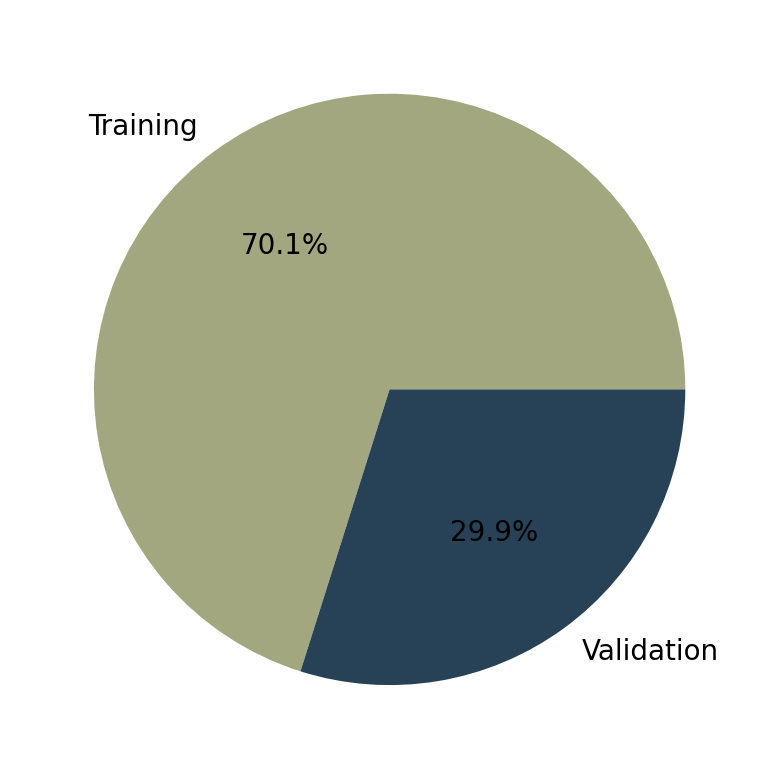

In [49]:
valid_size = 0.23

# Split the data into training and test sets
X_train, X_valid, Y_train, Y_valid = train_test_split(train_no_subscription, train_only_subscription, test_size=valid_size,  stratify=train_only_subscription)

# Checking Correct Split
Cond1 = X_train.shape[0] == Y_train.shape[0]
Cond2 = X_valid.shape[0] == Y_valid.shape[0]

#print("\nSame Size ?","\n\nFor Training:",Cond1,", For Validation:", Cond2)

PropTV = (X_valid.shape[0]/X_train.shape[0])*100
PropTR = (1-(X_valid.shape[0]/X_train.shape[0]))*100

#print("\nProportions between Training and Validation:","\n Training: ", round(PropTR,2),"%", "\n Validation: ",round(PropTV,2),"%")

mpl.rcParams['figure.dpi']= 200

mylabels = ["Training","Validation"]

y = np.array([PropTR,PropTV])

piecolors = [second_col,main_col]

plt.pie(y, labels = mylabels, colors = piecolors, autopct='%1.1f%%')
plt.show() 

# __Predictive Models__

In this part we will show some of the predictive models we fitted and among the best one which we used for the final kaggle preidciton. Down below we define funcitons that we used to evaluate the models, namely and ROC plot, a confusion matrix, and a way to plot the accuracy of training and validation. 

In [50]:
mpl.rcParams['figure.dpi']= 150

custom_cmap2 = mcolors.LinearSegmentedColormap.from_list("", [main_col, "white", second_col])

In [51]:
def plot_ROC(true, predicted):
    RocCurveDisplay.from_predictions(
        true,
        predicted,
        color=second_col,
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


def make_confusion_matrix(cf,
                          group_names= None,
                          categories= 'auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            specificity = cf[0,0] / (cf[0,0] + cf[0,1])
            sensitivity = cf[1,1] / (cf[1,0] + cf[1,1])
            stats_text = "\n\nAccuracy={:0.3f}   Precision={:0.3f}   Recall={:0.3f}\n      F1 Score={:0.3f}   Sensitivity{:0.3f}   Specificity={:0.3f}".format(
                accuracy,precision,recall,f1_score, sensitivity,specificity)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    plt.show()


def plot_training(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b--', label='Training')
    plt.plot(epochs, val_loss, 'r-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b--', label='Training')
    plt.plot(epochs, val_acc, 'r-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    plt.show()

## Random Forests

In [52]:
from sklearn.ensemble import RandomForestClassifier

### No Tuning

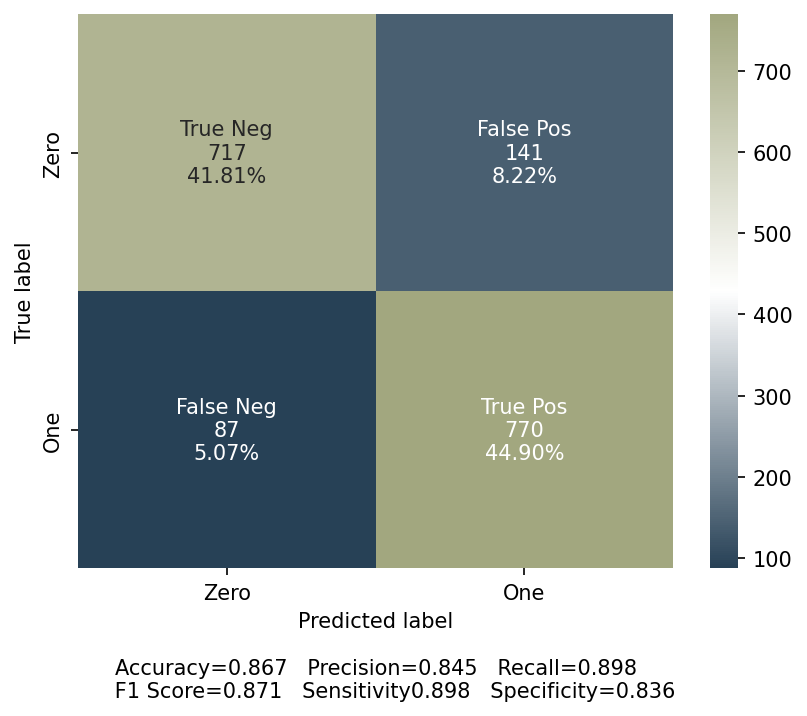

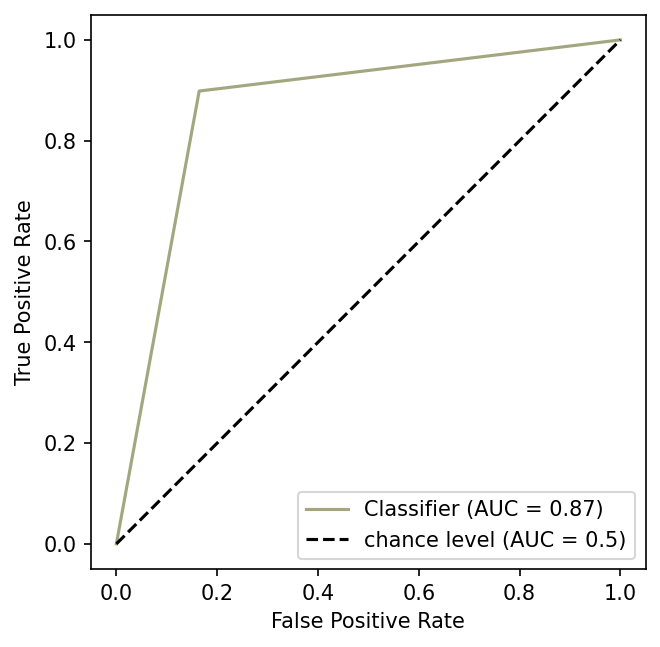

In [53]:
# create the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training data
rf.fit(X_train, Y_train)

# make predictions on the testing data
y_pred = rf.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)


### Tuning

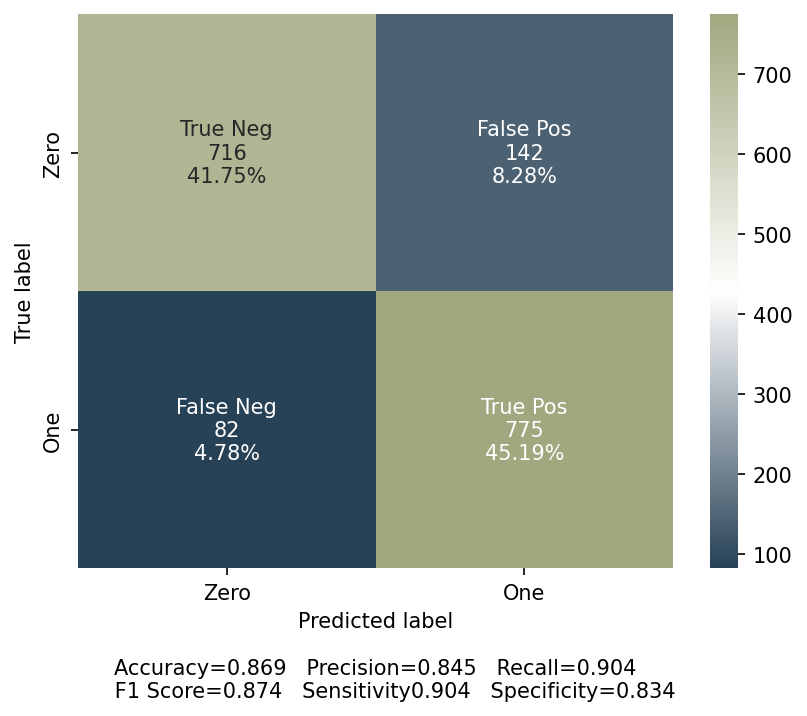

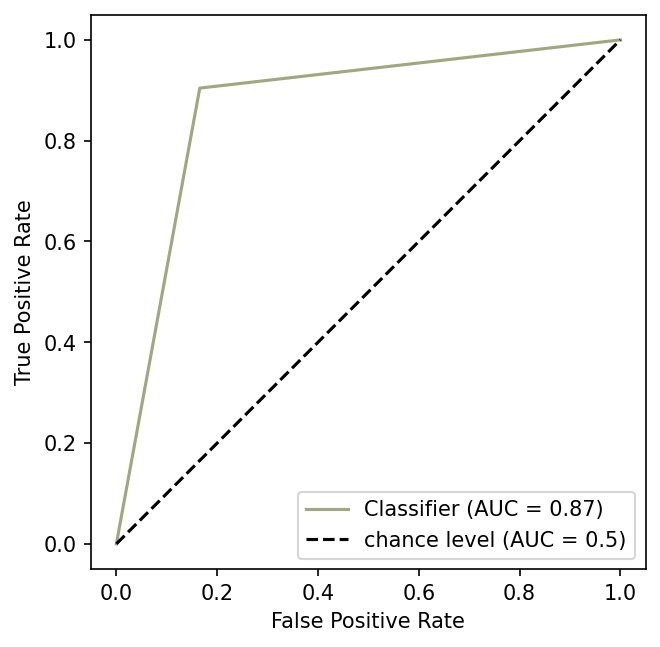

In [54]:
rf = RandomForestClassifier(random_state=42)

# set up the hyperparameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# set up the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)


rf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                            max_depth=grid_search.best_params_['max_depth'],
                            min_samples_split=grid_search.best_params_['min_samples_split'],
                            min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                            random_state=42)

# fit the model to the entire training data
rf.fit(X_train, Y_train)

# make predictions on the testing data
y_pred = rf.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## Bagging Trees

We perform Bootstrap Aggregation. 100 training boostrap samples are generated at first, for each of them a full grown tree is generated. The final training set prediction is the most commonly occurring predicted class, this is done by taking a majority vote on the 100 generated predictions. 
The aggregation process reduces the large variance a simple tree would have had, if the number of bootstrap sample is large enough the miss-classification error will stabilise.


In [63]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

### No Tuning

The tuning parameter within the model is the number of bootstrap samples we want to generate. In this instance generate the prediction using a base amount of sample of 100.

0.848806828078732


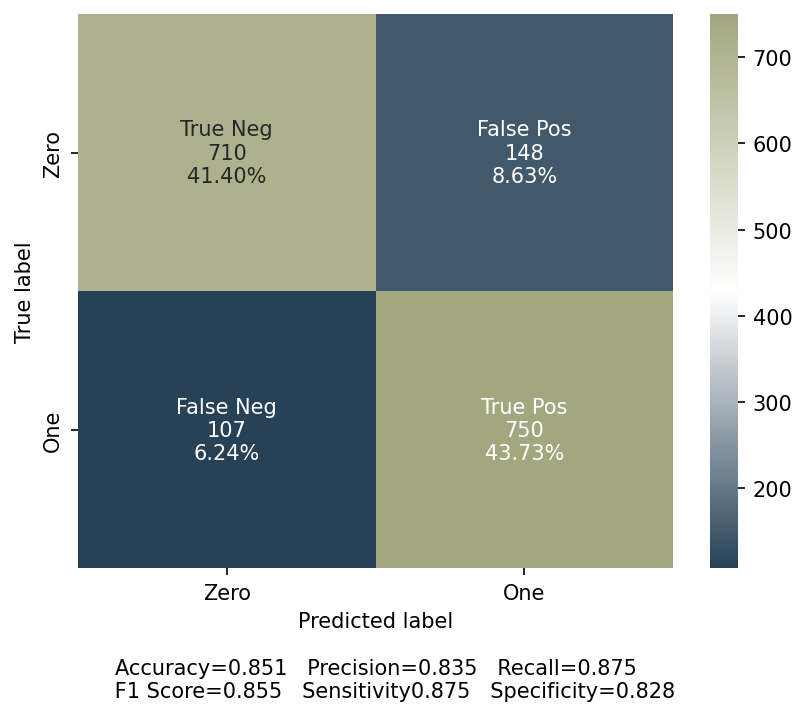

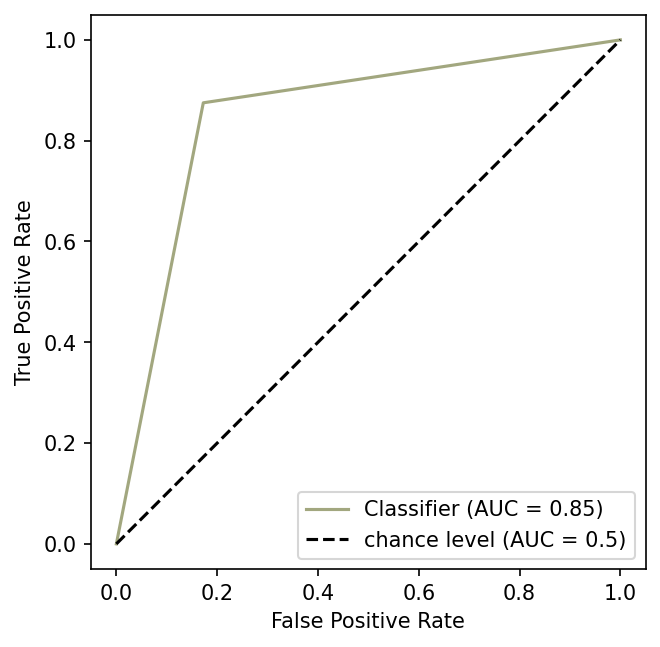

In [60]:

# create the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# create the Bagging model with 100 base estimators
bagging = BaggingClassifier(dt, n_estimators=100,oob_score=True, random_state=42)

# fit the model to the training data
bagging.fit(X_train, Y_train)


# make predictions on the testing data
y_pred = bagging.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)


### Tuning

In [65]:
param_grid = {'n_estimators': [50, 100, 200],
              'max_samples': [0.5, 1.0],
              'bootstrap': [True, False],
              'bootstrap_features': [True, False]}

# create the GridSearchCV object
grid_search = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42),
                           param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)

# print the best parameter
print("Best Parameters:", grid_search.best_params_)

# create a new Bagging model with the best hyperparameters found during the hyperparameter tuning process
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                            n_estimators=grid_search.best_params_['n_estimators'],
                            max_samples=grid_search.best_params_['max_samples'],
                            bootstrap=grid_search.best_params_['bootstrap'],
                            bootstrap_features=grid_search.best_params_['bootstrap_features'],
                            random_state=42)

# fit the model to the entire training data
bagging.fit(X_train, Y_train)

y_pred = bagging.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

# OOB error
print(1-bagging.oob_score_)


KeyboardInterrupt: 

## Boosting Trees

In [483]:
from sklearn.ensemble import GradientBoostingClassifier

### No Tuning

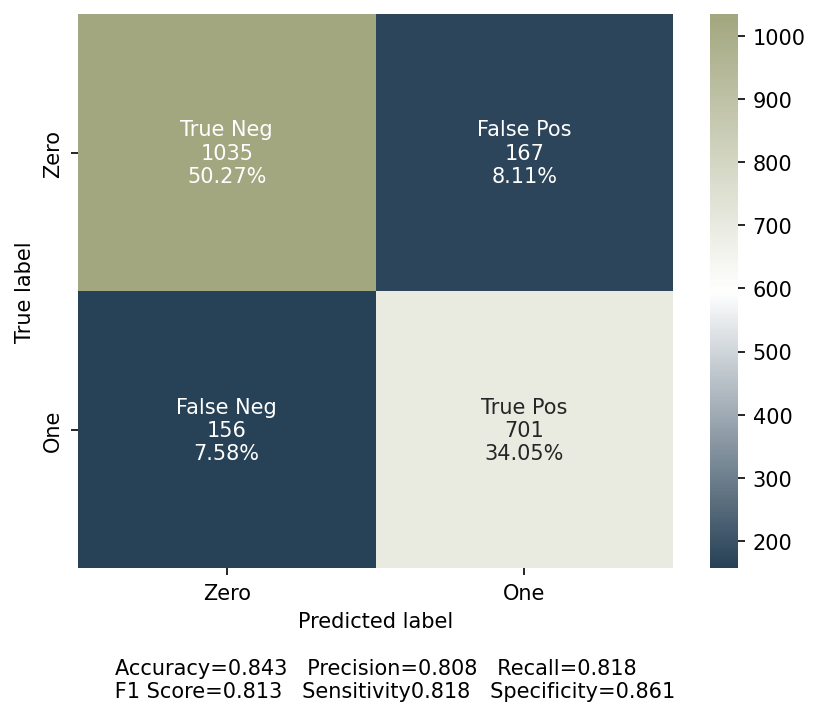

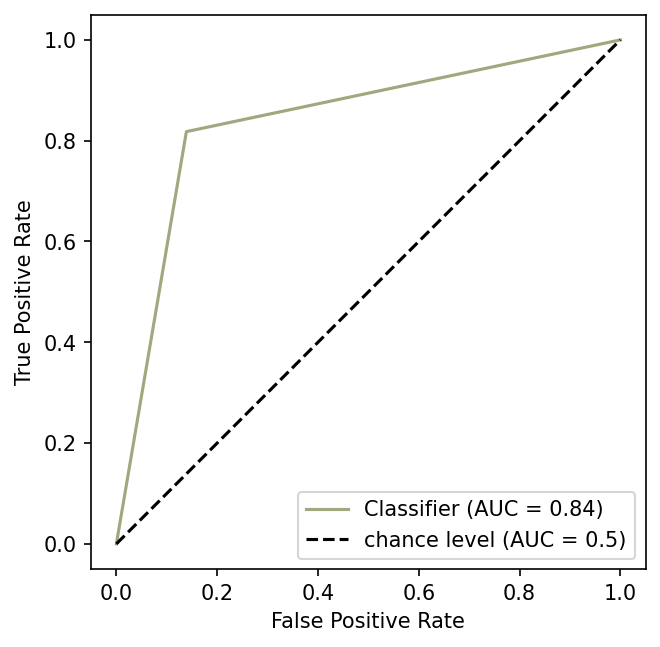

In [484]:
gb = GradientBoostingClassifier(random_state=42)

# fit the model to the training data
gb.fit(X_train, Y_train)

# make predictions on the testing data
y_pred = gb.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

### Tuning

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}


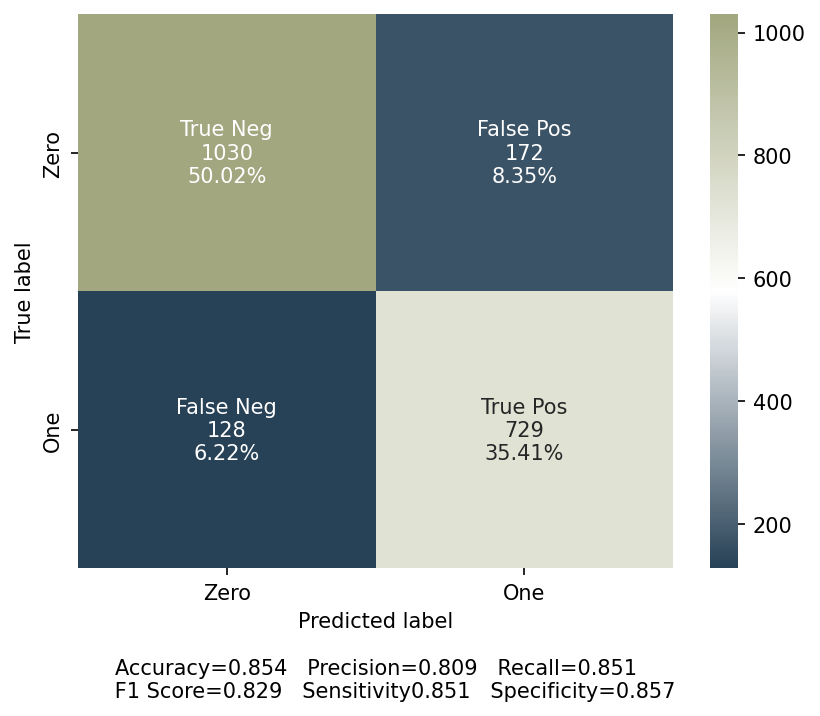

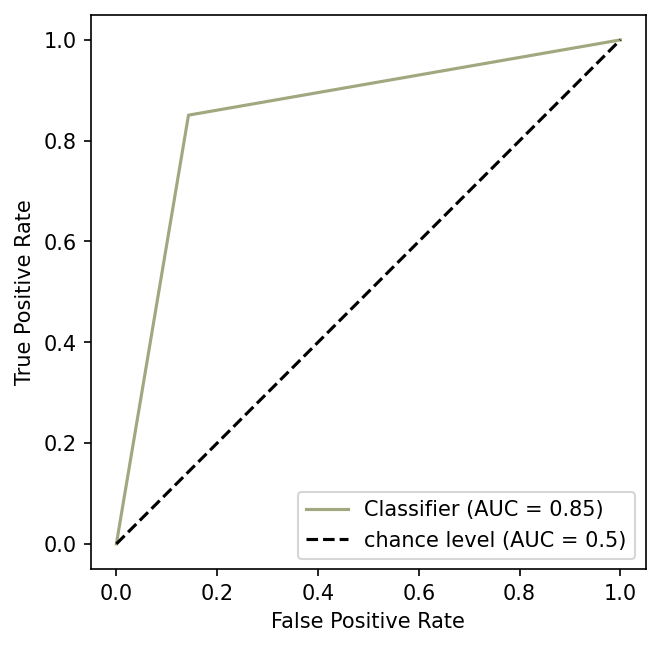

In [485]:
gb = GradientBoostingClassifier(random_state=42)

# set up the hyperparameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 1.0],
              'max_depth': [2, 3, 4],
              'subsample': [0.5, 0.75, 1.0]}

# create the GridSearchCV object
grid_search = GridSearchCV(gb, param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)

# print the best hyperparameters found during the hyperparameter tuning process
print("Best hyperparameters: ", grid_search.best_params_)

# create a new Gradient Boosting model with the best hyperparameters found during the hyperparameter tuning process
gb = GradientBoostingClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                learning_rate=grid_search.best_params_['learning_rate'],
                                max_depth=grid_search.best_params_['max_depth'],
                                subsample=grid_search.best_params_['subsample'],
                                random_state=42)

# fit the model to the entire training data
gb.fit(X_train, Y_train)

# make predictions on the testing data
y_pred = gb.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## Linear Discriminant Analysis (LDA)

Here we fit a linear discriminat analysis to the training data. LDA basically tries to best seperate the data linearly on a combination of predictors. Thereby it is assumed that the variances of the two classes are similar. 

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

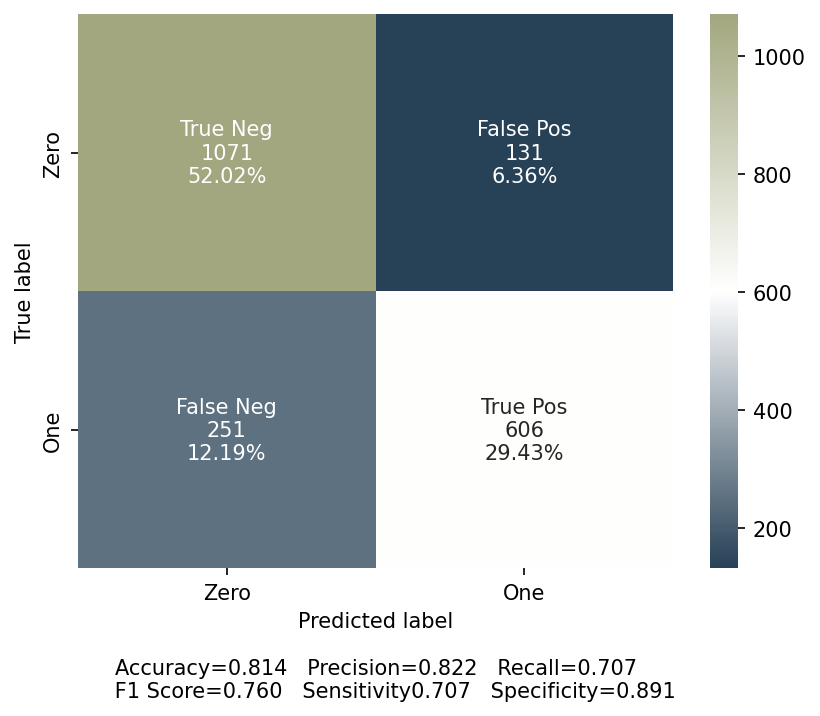

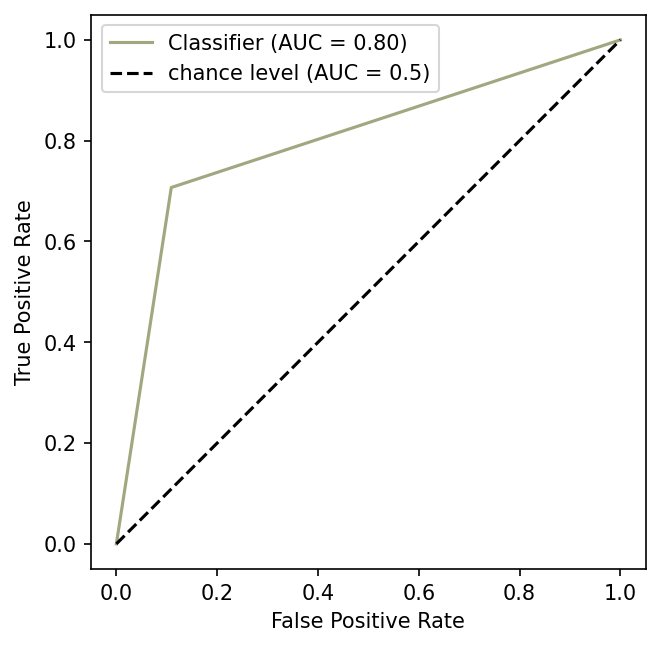

In [44]:
lda = LinearDiscriminantAnalysis()

# fit the LDA model to the training data
lda.fit(X_train, Y_train)

# make predictions on the testing data using the trained LDA model
y_pred = lda.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'],cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

We can see from the confusion matrix and the ROC plot that it is not per see a bad classifier but also not a necessarily good one. 

## Support Vector Machines (SVM)

Following in this part we fit a support vector machine. The support vector machine looks for occurences in the data that are at the decision boundaries and fits a hyperplane which has the most distance to all of the support vectors chosen. Thereby one can use the kernel trick to get a non-linear decision boundary. 

In [46]:
from sklearn import svm

### No Tuning

Here we fit a standard SVC without chaning any of the tuning parameters.

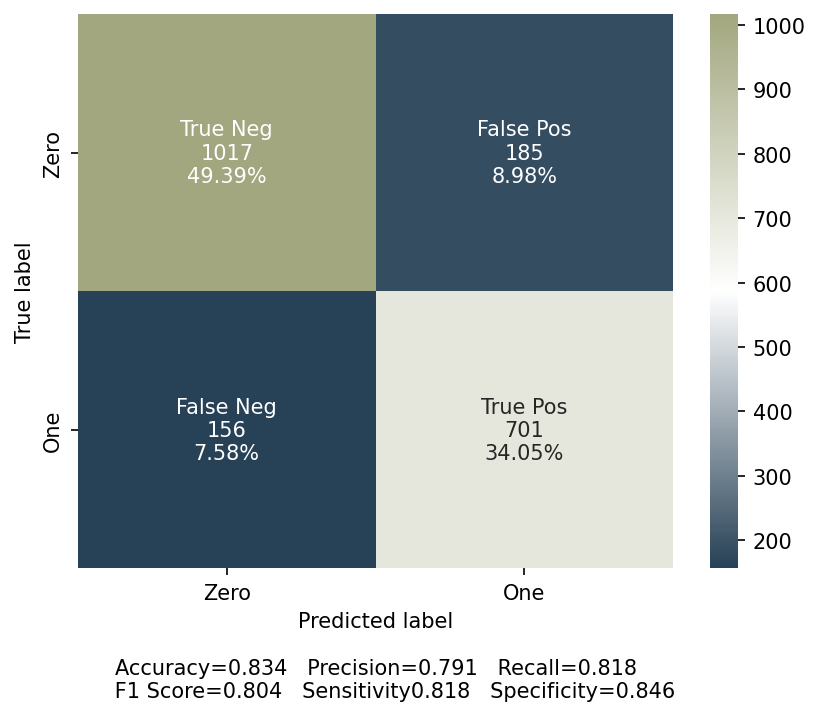

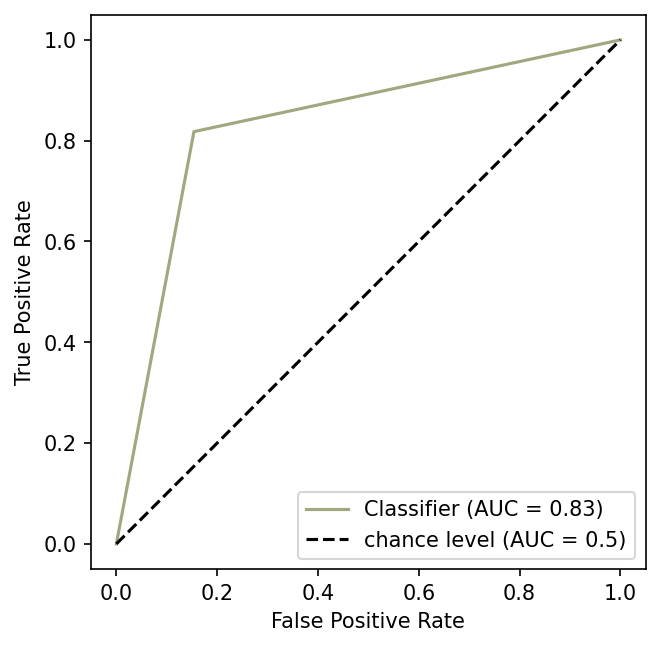

In [67]:
svm_model = svm.SVC()

# fit the SVM model to the training data
svm_model.fit(X_train, Y_train)

# make predictions on the testing data using the trained SVM model
y_pred = svm_model.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

The basic model fit without any tuning is better than LDA but not really good which is why we try to tune it a bit. In this case we change the parameters C, kernel, and gamma. C is here for regularization, the kernel decides on the type of decision boundary that will be used while gamma decides on the distance that points can have from the boundary.

### Tuning

In [60]:
svm_model = svm.SVC()

# set up the hyperparameter grid to search over
param_grid = {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto', 0.1, 0.2, 0.3, 0.4]}

# create the GridSearchCV object
grid_search = GridSearchCV(svm_model, param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)

# print the best hyperparameters found during the hyperparameter tuning process
print("Best hyperparameters: ", grid_search.best_params_)

# create a new SVM model with the best hyperparameters found during thehyperparameter tuning process
svm_model = svm.SVC(C=grid_search.best_params_['C'],
                    kernel=grid_search.best_params_['kernel'],
                    gamma=grid_search.best_params_['gamma'])

# fit the SVM model to the training data
svm_model.fit(X_train, Y_train)

# make predictions on the testing data using the trained SVM model
y_pred = svm_model.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

KeyboardInterrupt: 

Even though the model gets better it doesn't beat our best model. This makes sense as support vector machines are still bound to simple decision boundaries compared to other methods. As our data is not easily seperable it makes sense that we can not classify it correctly with this model. 

## XGBoost

In [122]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

XGBoost is an open-source software library that implements optimized distributed gradient boosting machine learning algorithms. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems. XGBoost is a scalable and highly accurate implementation of gradient boosting that pushes the limits of computing power for boosted tree algorithms, being built largely for energizing machine learning model performance and computational speed. It gained significant favor in the last few years as a result of helping individuals and teams win virtually every Kaggle structured data competition. XGBoost has a large and growing list of data scientists globally that are actively contributing to XGBoost open source development.

https://www.nvidia.com/en-us/glossary/data-science/xgboost/

XGBoost is a gradient-boosting decision tree algorithm that creates decision trees in sequential form and assigns weights to all independent variables, which are then fed into the decision tree to predict results. The weights of variables predicted incorrectly by the tree are increased, and these variables are fed into the second decision tree. The individual classifiers/predictors then ensemble to give a strong and more precise model. XGBoost can work on regression, classification, ranking, and user-defined prediction problems.

https://www.geeksforgeeks.org/xgboost/

### No Tuning

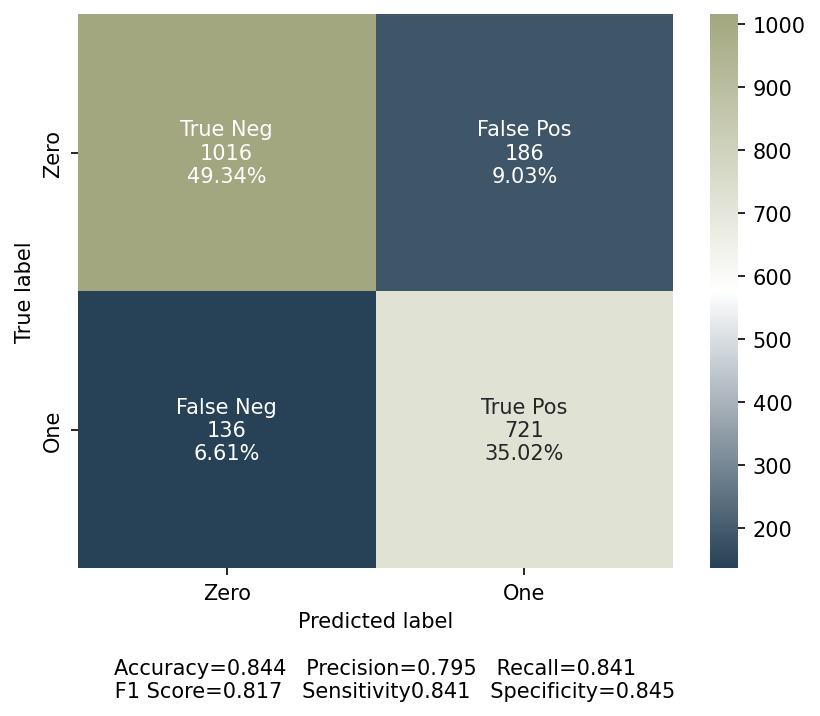

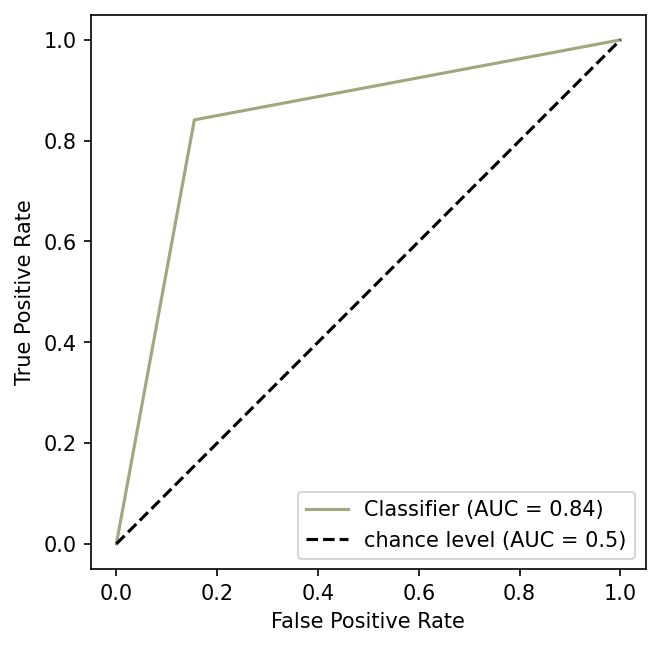

In [24]:
# Instantiate the XGBClassifier class
xg_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the model on the training data
xg_clf.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = xg_clf.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)


### Tuning V1

[0]	validation_0-error:0.17656	validation_0-logloss:0.56468	validation_1-error:0.20204	validation_1-logloss:0.57498
[1]	validation_0-error:0.15233	validation_0-logloss:0.48906	validation_1-error:0.16416	validation_1-logloss:0.50466
[2]	validation_0-error:0.14812	validation_0-logloss:0.43840	validation_1-error:0.16367	validation_1-logloss:0.46187
[3]	validation_0-error:0.14711	validation_0-logloss:0.40432	validation_1-error:0.16513	validation_1-logloss:0.43517
[4]	validation_0-error:0.14043	validation_0-logloss:0.37727	validation_1-error:0.16319	validation_1-logloss:0.41418
[5]	validation_0-error:0.13724	validation_0-logloss:0.35845	validation_1-error:0.15979	validation_1-logloss:0.39998
[6]	validation_0-error:0.13434	validation_0-logloss:0.34262	validation_1-error:0.15930	validation_1-logloss:0.38656
[7]	validation_0-error:0.13100	validation_0-logloss:0.32903	validation_1-error:0.15833	validation_1-logloss:0.37659
[8]	validation_0-error:0.12999	validation_0-logloss:0.31925	validation_1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-error:0.09560	validation_0-logloss:0.23059	validation_1-error:0.13890	validation_1-logloss:0.33934
[30]	validation_0-error:0.09517	validation_0-logloss:0.22902	validation_1-error:0.13939	validation_1-logloss:0.33889
[31]	validation_0-error:0.09415	validation_0-logloss:0.22666	validation_1-error:0.13793	validation_1-logloss:0.33961
[32]	validation_0-error:0.09154	validation_0-logloss:0.22524	validation_1-error:0.13745	validation_1-logloss:0.33923
[33]	validation_0-error:0.09140	validation_0-logloss:0.22246	validation_1-error:0.13890	validation_1-logloss:0.33906
[34]	validation_0-error:0.08922	validation_0-logloss:0.21907	validation_1-error:0.14036	validation_1-logloss:0.33843
[35]	validation_0-error:0.08748	validation_0-logloss:0.21605	validation_1-error:0.14182	validation_1-logloss:0.33698
[36]	validation_0-error:0.08646	validation_0-logloss:0.21439	validation_1-error:0.14230	validation_1-logloss:0.33693
[37]	validation_0-error:0.08603	validation_0-logloss:0.21361	val

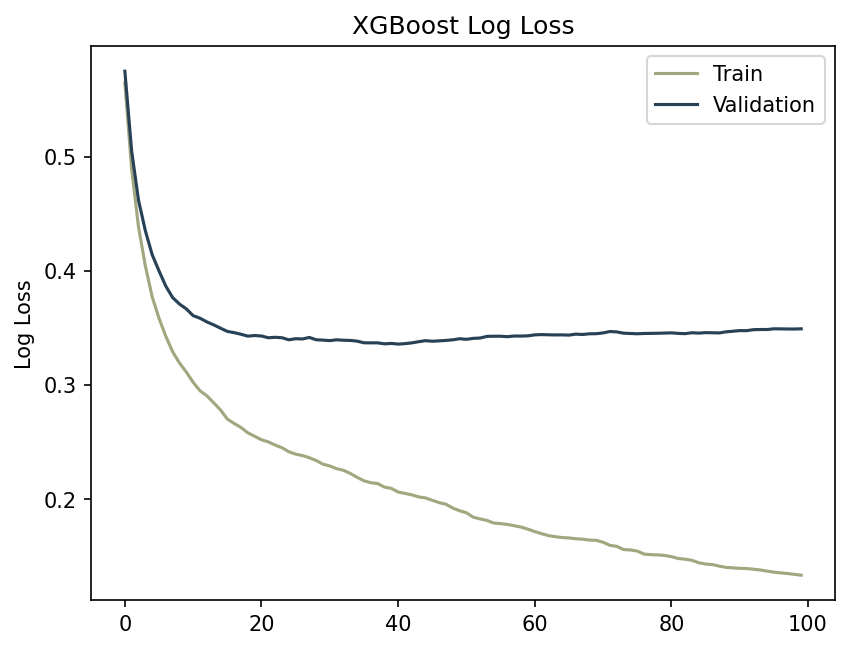

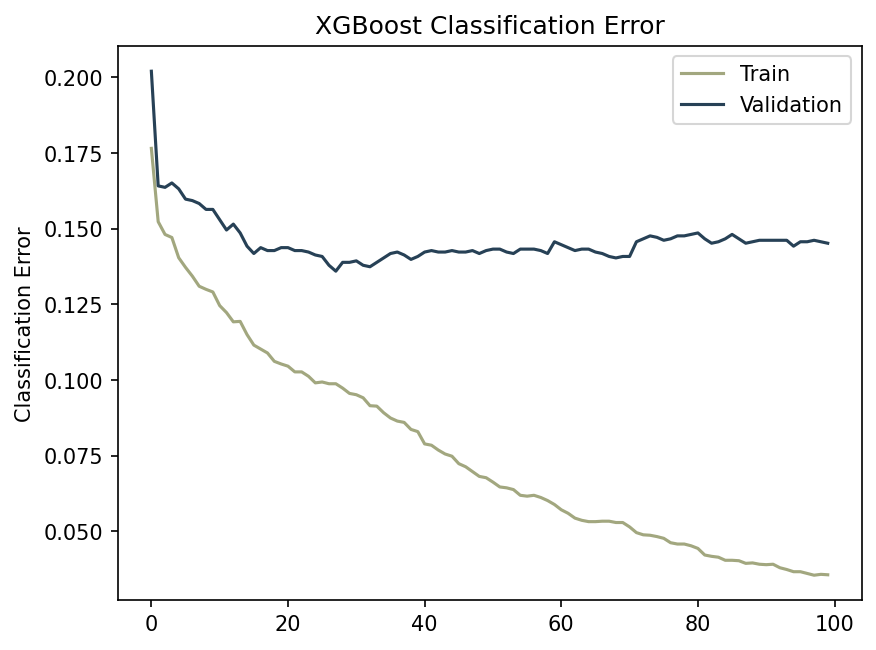

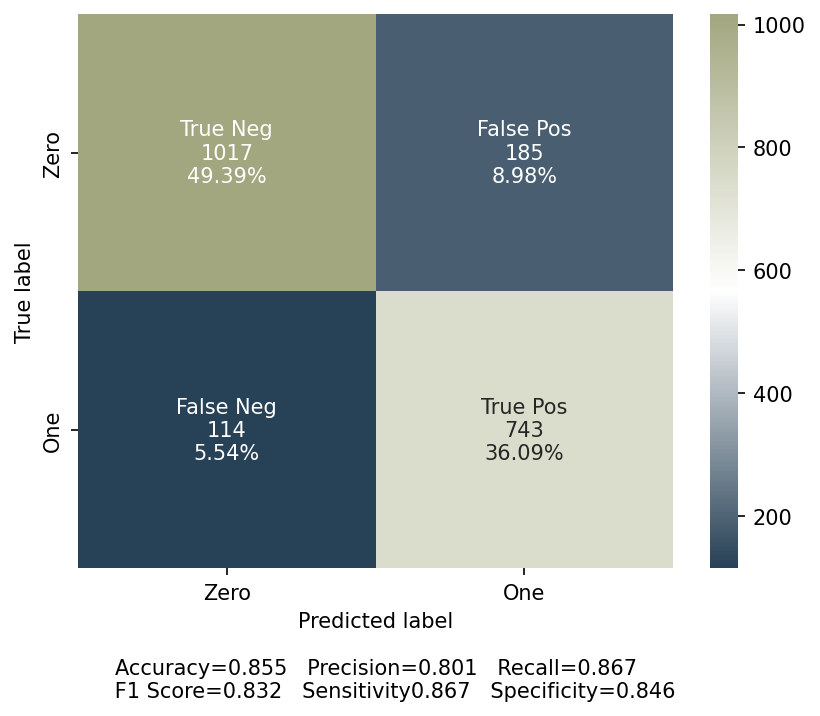

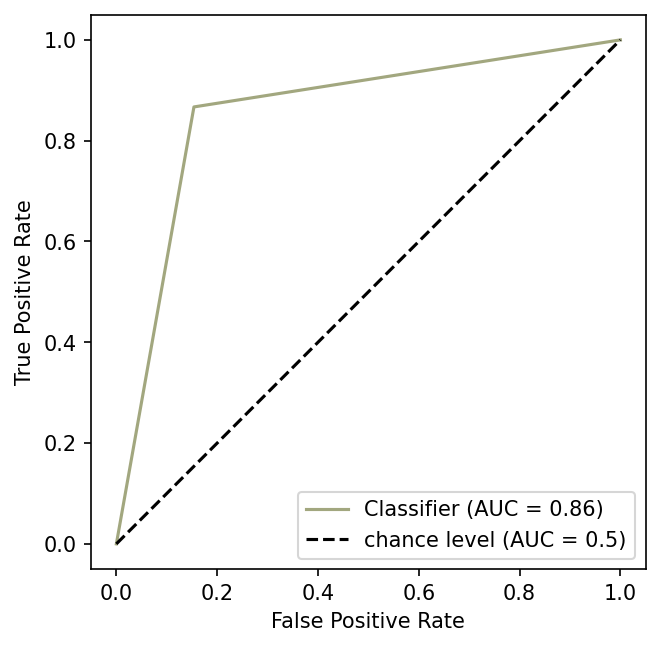

In [26]:

# fit model no training data
model = XGBClassifier()
eval_set = [(X_train, Y_train), (X_valid, Y_valid)]
model.fit(X_train, Y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_valid)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(Y_valid, predictions)
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], color=second_col,label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], color=main_col,label='Validation')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'],color=second_col, label='Train')
ax.plot(x_axis, results['validation_1']['error'], color=main_col,label='Validation')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

### Tuning V2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:835:

Best hyperparameters:  {'subsample': 0.7999999999999999, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 450, 'max_depth': 7, 'learning_rate': 0.04, 'gamma': 0, 'colsample_bytree': 0.6}
Best score:  0.8587356677371325


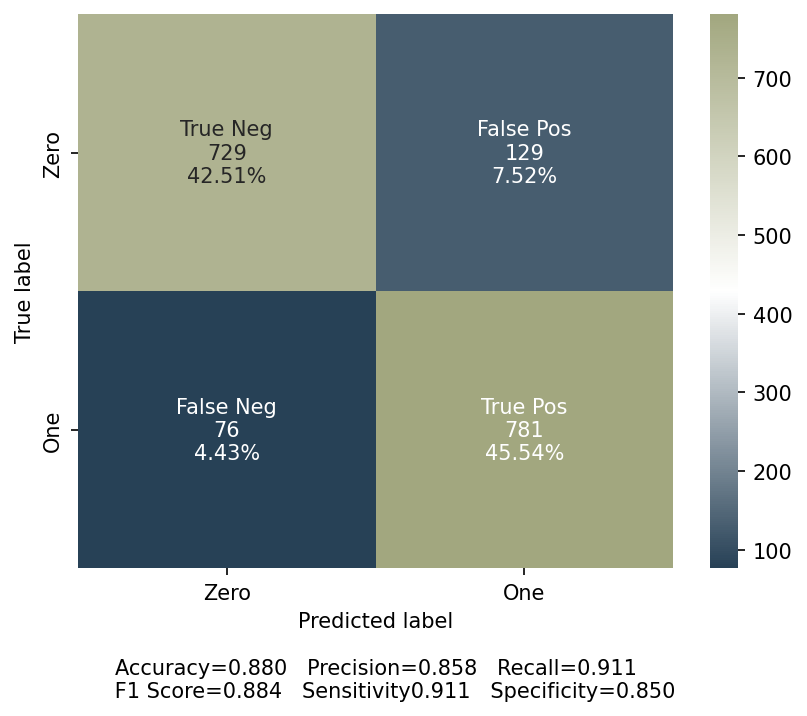

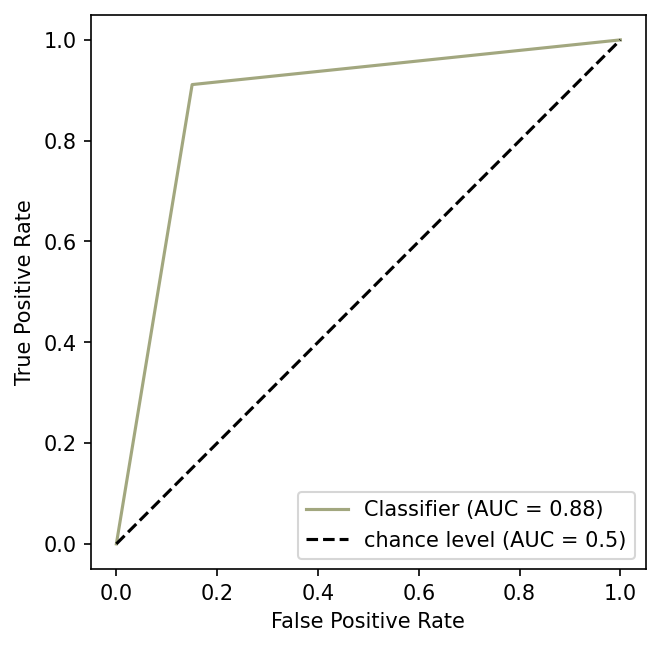

In [135]:
# Define the hyperparameters and their distributions
params = {
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'max_depth': np.arange(3, 10),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'n_estimators': np.arange(50, 500, 50),
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1, 5],
    'reg_lambda': [0, 0.1, 0.5, 1, 5],
}

# Instantiate the XGBClassifier class
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=123)

# Perform a randomized search to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params, n_iter=100,
                                   scoring='accuracy', cv=5, n_jobs=-1, random_state=123)
random_search.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_valid, Y_valid)], verbose=0)

# Print the best hyperparameters and the best score
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

best_params = random_search.best_params_

final_xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=123, **best_params)
final_xgb_clf.fit(X_train, Y_train)

# Make predictions onthe test set using the final model
y_pred_final = final_xgb_clf.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred_final), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred_final)


## LightGBM

In [27]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

LightGBM is a gradient boosting ensemble method that uses decision trees for classification and regression and is optimized for high performance with distributed systems. It creates decision trees that grow leaf-wise and uses a histogram-based method to bucket data into bins, which can be optimized for sparse datasets. LightGBM also features exclusive feature bundling to reduce dimensionality and Gradient-based One Side Sampling (GOSS) for sampling the dataset, where data points with larger gradients are weighted higher and instances that have not been used well for training contribute more. GOSS is typically better than random sampling given the same sampling rate.

https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/how-lightgbm-works.htm

### No Tuning

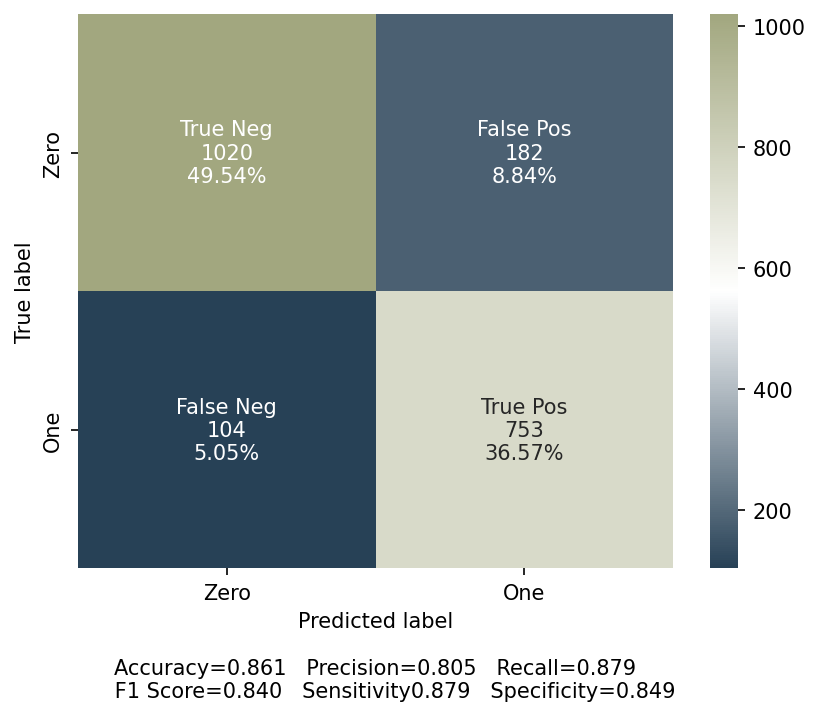

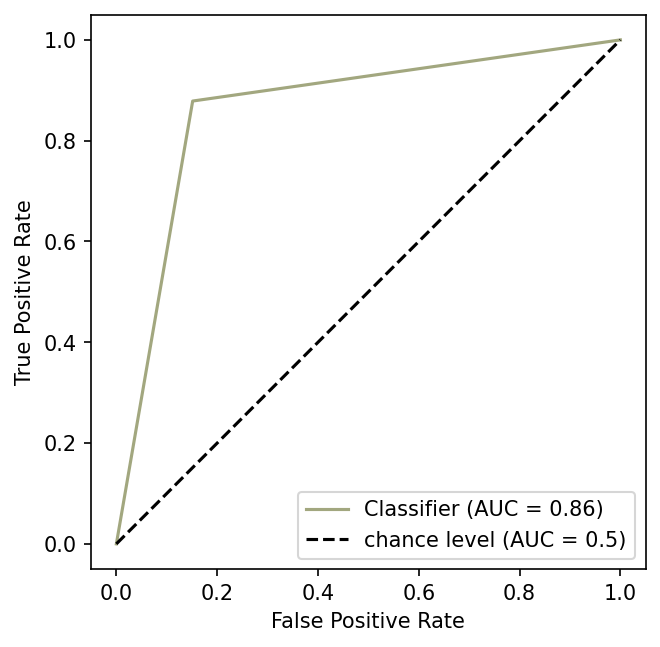

In [28]:
# create the LGBMClassifier model
lgb_model = LGBMClassifier()

# train the LGBMClassifier model using the training data
lgb_model.fit(X_train, Y_train)

# make predictions on the testing data using the trained LGBMClassifier model
y_pred = lgb_model.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

### Tuning

Best hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 20, 'num_leaves': 31, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.6}


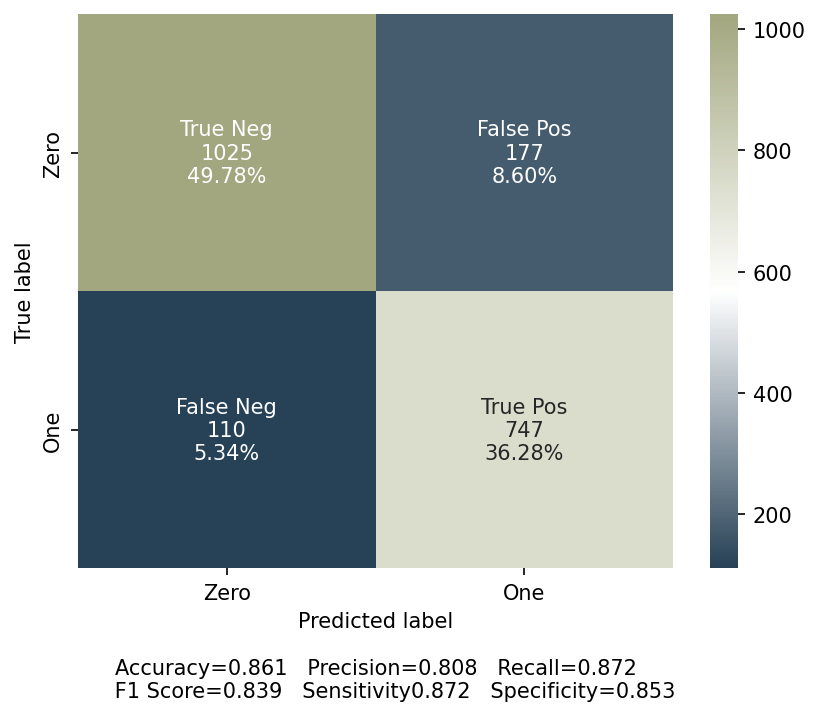

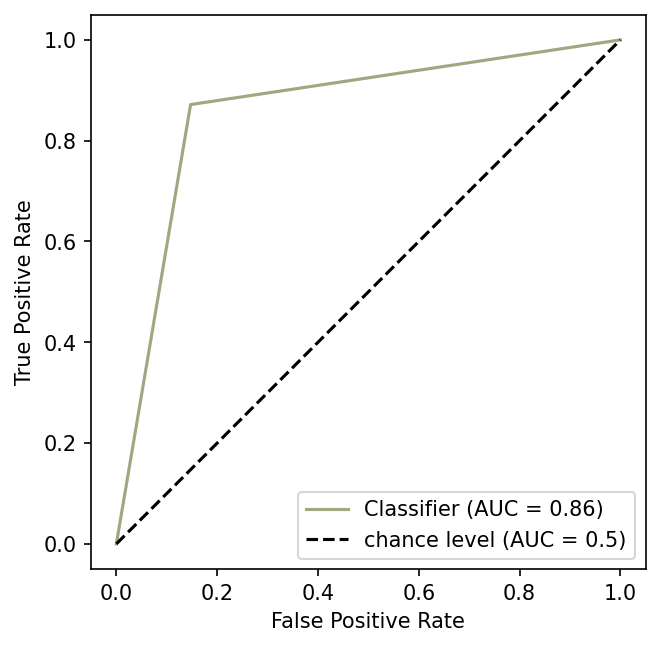

In [29]:
# Define the LightGBM model
model = lgb.LGBMClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31, 63, 127],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters and corresponding AUC score
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict_proba(X_valid)[:, 1]
y_pred = (y_pred > 0.5).astype(int)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## CatBoost

In [32]:
import catboost as cb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

CatBoost is a supervised machine learning technique that employs regression and classification using decision trees. It is intended to operate with categorical data and enhances the original approach for quicker implementation by using gradient boosting. Using a technique known as ordered encoding, CatBoost has the unique ability to directly ingest a mixture of category and non-categorical explanatory information. The symmetric trees used by CatBoost have the identical split condition applied to each decision node at each depth level. It can be quicker than other approaches like XGBoost and keeps certain characteristics from earlier algorithms including cross-validation, regularization, and missing value support. The performance of CatBoost is good for both small and big datasets.

https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/how-catboost-works.htm 


### No Tuning

0:	learn: 0.6364461	total: 58.9ms	remaining: 5.83s
1:	learn: 0.5914606	total: 61.3ms	remaining: 3s
2:	learn: 0.5560489	total: 63.6ms	remaining: 2.06s
3:	learn: 0.5266232	total: 65.9ms	remaining: 1.58s
4:	learn: 0.5065321	total: 67.9ms	remaining: 1.29s
5:	learn: 0.4870657	total: 70ms	remaining: 1.1s
6:	learn: 0.4706666	total: 72.2ms	remaining: 959ms
7:	learn: 0.4586148	total: 74.5ms	remaining: 856ms
8:	learn: 0.4457154	total: 76.6ms	remaining: 774ms
9:	learn: 0.4352360	total: 78.8ms	remaining: 709ms
10:	learn: 0.4262530	total: 80.9ms	remaining: 655ms
11:	learn: 0.4186209	total: 83ms	remaining: 609ms
12:	learn: 0.4114481	total: 85.3ms	remaining: 571ms
13:	learn: 0.4061050	total: 87.3ms	remaining: 536ms
14:	learn: 0.4005093	total: 89.3ms	remaining: 506ms
15:	learn: 0.3958632	total: 91.3ms	remaining: 479ms
16:	learn: 0.3917998	total: 93.4ms	remaining: 456ms
17:	learn: 0.3882721	total: 95.5ms	remaining: 435ms
18:	learn: 0.3855802	total: 97.8ms	remaining: 417ms
19:	learn: 0.3822322	total: 10

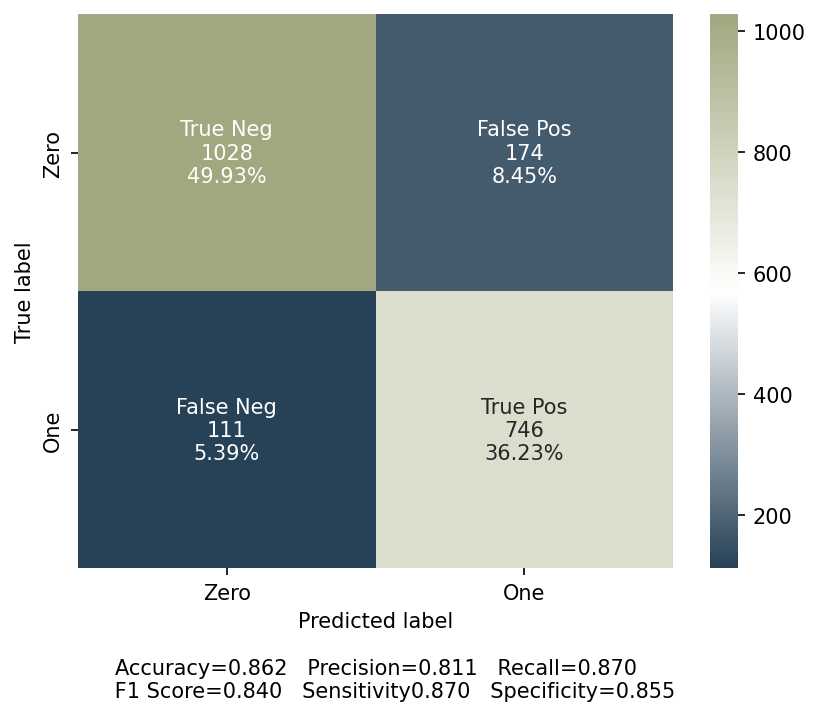

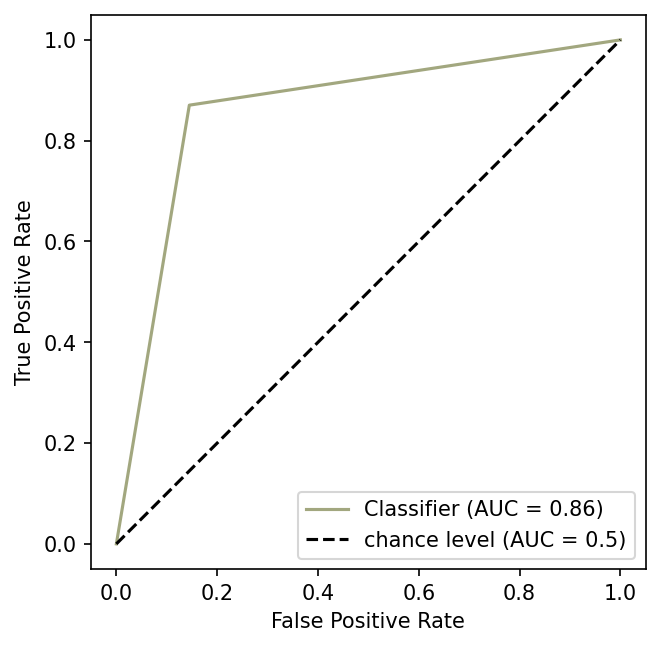

In [33]:
model = cb.CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
model.fit(X_train, Y_train)

y_pred = model.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

### Tuning

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

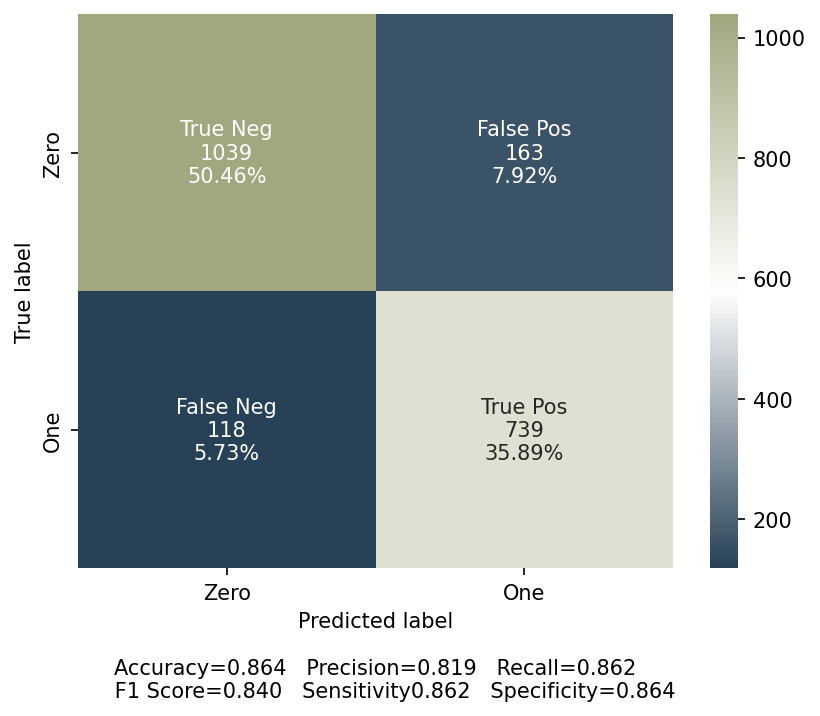

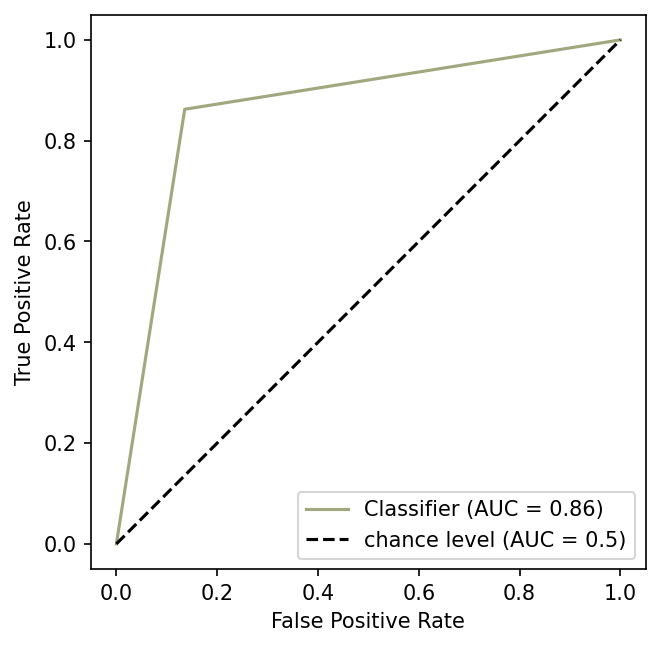

In [35]:

catboost = CatBoostClassifier(
    iterations=50,
    random_seed=42,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

catboost.fit(
    X_train, Y_train,
    eval_set=(X_valid, Y_valid),
    verbose=False,
    plot=True
)

y_pred = catboost.predict(X_valid)

make_confusion_matrix(confusion_matrix(Y_valid, y_pred), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)
plot_ROC(Y_valid, y_pred)

## Neural Network

In [76]:
# train_c = train.copy()
# for col in train_c[train_categorical].columns:
#     train_c[col].cat.add_categories("Missing").fillna("Missing")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

### Tuning

In [70]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, input_dim=74, activation='relu'))
model.add(keras.layers.Activation('sigmoid'))
model.add(keras.layers.Dropout(name="drop1", rate=0.2))
model.add(keras.layers.Dense(50, input_dim=74, activation='relu'))
model.add(keras.layers.Activation('sigmoid'))
model.add(keras.layers.Dropout(name="drop2", rate=0.2))
model.add(keras.layers.Dense(50, input_dim=74, activation='relu'))
model.add(keras.layers.Activation('sigmoid'))
model.add(keras.layers.Dropout(name="drop3", rate=0.2))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Activation('sigmoid'))
model.add(keras.layers.Dropout(name="drop4", rate=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = "sparse_categorical_crossentropy", # as y is encoded as a vector of labels and not as a one hot matrix
              optimizer = optimizer,
              metrics = ["accuracy"])

history = model.fit(X_train, Y_train,
                    validation_data=(X_valid, Y_valid), 
                    batch_size = 64,
                    epochs=100)
model.save("checkpoints/dense_nn.h5")

plot_training(history.history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                3750      
                                                                 
 activation_4 (Activation)   (None, 50)                0         
                                                                 
 drop1 (Dropout)             (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 activation_5 (Activation)   (None, 50)                0         
                                                                 
 drop2 (Dropout)             (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 50)               

ValueError: in user code:

    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 74), found shape=(None, 81)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                3750      
                                                                 
 dense_16 (Dense)            (None, 30)                1530      
                                                                 
 drop2 (Dropout)             (None, 30)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                 62        
                                                                 
Total params: 5342 (20.87 KB)
Trainable params: 5342 (20.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
108/108 [==============================] - 0s 2ms/step - loss: 0.5448 - accuracy: 0.7312 - val_loss: 0.4179 - val_accuracy: 0.8271
Epoch 2/100
108/108 [==============================] - 0s 914us/step - loss: 0.3937 - accuracy: 0.8298 - val_loss: 0.3833 - val_accuracy: 0.8388
Epoch 3/100
108/108 [==============================] - 0s 897us/step - loss: 0.3626 - accuracy: 0.8477 - val_loss: 0.3709 - val_accuracy: 0.8456
Epoch 4/100
108/108 [==============================] - 0s 895us/step - loss: 0.3505 - accuracy: 0.8509 - val_loss: 0.3677 - val_accuracy: 0.8475
Epoch 5/100
108/108 [==============================] - 0s 886us/step - loss: 0.3413 - accuracy: 0.8571 - val_loss: 0.3665 - val_accuracy: 0.8460
Epoch 6/100
108/108 [==============================] - 0s 909us/step - loss: 0.3296 - accuracy: 0.8601 - val_loss: 0.3593 - val_accuracy: 0.8509
Epoch 7/100
108/108 [==============================] - 0s 918us/step - loss: 0.3217 - accuracy: 0.8629 - val_loss: 0.3574 - val_accu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


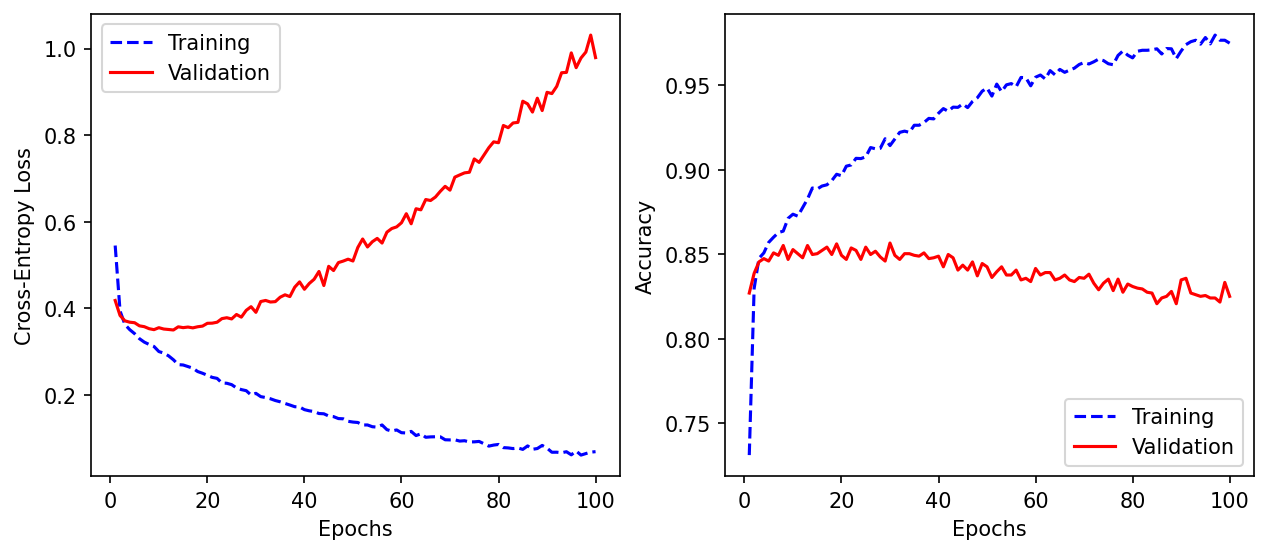

In [516]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, input_dim=74, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dropout(name="drop2", rate=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = "sparse_categorical_crossentropy", # as y is encoded as a vector of labels and not as a one hot matrix
              optimizer = optimizer,
              metrics = ["accuracy"])

history = model.fit(X_train, Y_train,
                    validation_data=(X_valid, Y_valid), 
                    batch_size = 64,
                    epochs=100)
model.save("checkpoints/dense_nn2.h5")

plot_training(history.history)

In [71]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(300, input_dim=74, activation='relu'))
model.add(keras.layers.Dropout(name="drop2", rate=0.2))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(name="drop3", rate=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()
optimizer = keras.optimizers.Adam(learning_rate=0.0001) # SGD, Nadam, 

model.compile(loss = "sparse_categorical_crossentropy", # as y is encoded as a vector of labels and not as a one hot matrix
              optimizer = optimizer,
              metrics = ["accuracy"])

history = model.fit(X_train, Y_train,
                    validation_data=(X_valid, Y_valid), 
                    batch_size = 64,
                    epochs=100)
model.save("checkpoints/dense_nn3.h5")

plot_training(history.history)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 300)               22500     
                                                                 
 drop2 (Dropout)             (None, 300)               0         
                                                                 
 dense_11 (Dense)            (None, 100)               30100     
                                                                 
 drop3 (Dropout)             (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 2)                 202       
                                                                 
Total params: 52,802
Trainable params: 52,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


ValueError: in user code:

    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 74), found shape=(None, 81)


In [518]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="checkpoints/model_epoch={epoch:02d}_val_accuracy={val_accuracy:.2f}.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

history = model.fit(X_train, Y_train,
                    validation_data=(X_valid, Y_valid), 
                    batch_size = 64,
                    epochs=100, callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/100
108/108 [==============================] - 0s 2ms/step - loss: 0.1873 - accuracy: 0.9227 - val_loss: 0.3826 - val_accuracy: 0.8519
Epoch 2/100
108/108 [==============================] - 0s 1ms/step - loss: 0.1916 - accuracy: 0.9217 - val_loss: 0.3801 - val_accuracy: 0.8558
Epoch 3/100
  1/108 [..............................] - ETA: 0s - loss: 0.1274 - accuracy: 0.9688

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 0s 1ms/step - loss: 0.1870 - accuracy: 0.9254 - val_loss: 0.3804 - val_accuracy: 0.8504
Epoch 4/100
108/108 [==============================] - 0s 1ms/step - loss: 0.1829 - accuracy: 0.9289 - val_loss: 0.3830 - val_accuracy: 0.8524
Epoch 5/100
108/108 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.9286 - val_loss: 0.3865 - val_accuracy: 0.8543
Epoch 6/100
108/108 [==============================] - 0s 1ms/step - loss: 0.1872 - accuracy: 0.9247 - val_loss: 0.3864 - val_accuracy: 0.8509
Epoch 7/100
108/108 [==============================] - 0s 1ms/step - loss: 0.1825 - accuracy: 0.9278 - val_loss: 0.3858 - val_accuracy: 0.8528
Epoch 7: early stopping


# __Best Predictive Model__

Here we show our final model for the Kaggle Competition

<br>

***

__ML Unige 2023: Advertisement Impact Prediction__

Predicting customer subscriptions from an advertisement campaign

***
<br>

https://www.kaggle.com/competitions/ml-unige-2023/submissions 

## XGBoost with Tuning (No Overfitting)

<center>
<img src="XG-Boost-FINAL-01.png" width="800">
</center>
<center>
Introduction to XGBoost in Python. (2020). Quantitative Finance & Algo Trading Blog by QuantInsti. https://blog.quantinsti.com/xgboost-python/
</center>

### Confusion Matrix

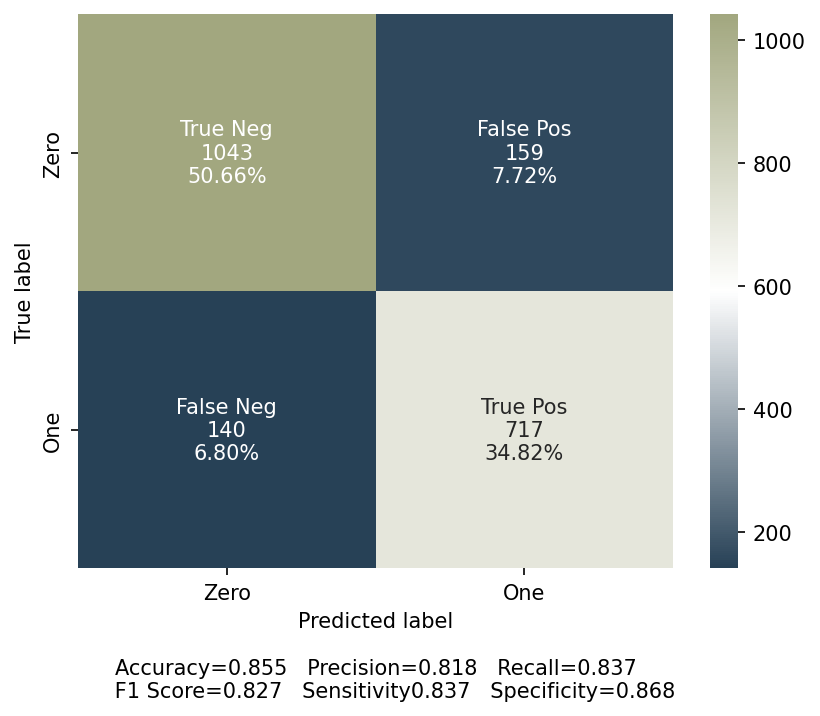

In [16]:
make_confusion_matrix(confusion_matrix(Y_valid, y_pred_final), group_names=['True Neg','False Pos','False Neg','True Pos'],  categories=['Zero', 'One'], cmap=custom_cmap2)

### ROC

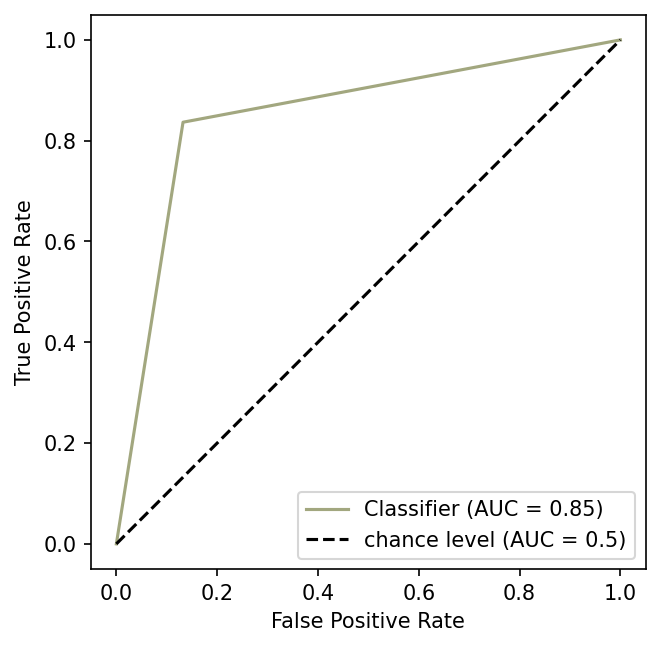

In [17]:
plot_ROC(Y_valid, y_pred_final)

# __Kaggle Competition__

## Best Predictive Model Fitted with 100% Train - XGBoost (Tuning V2)

In [136]:
final_xgb_clf.fit(train_no_subscription,train_only_subscription)

y_test_pred = final_xgb_clf.predict(test_hot) 

Predictions_On_Test = pd.DataFrame({'subscription': y_test_pred}).reset_index()

Predictions_On_Test = Predictions_On_Test.rename(columns={Predictions_On_Test.columns[0]: 'Id'})

pd.DataFrame(Predictions_On_Test).to_csv("Predictions_On_Test_Kaggle.csv",index=False)

print(y_test_pred.shape[0], "predictions correctly exported")

y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred

3837 predictions correctly exported


0
0     0
1     1
2     0
3     0
4     1
...  ..
3832  0
3833  1
3834  0
3835  1
3836  1

[3837 rows x 1 columns]

***
<br>
<center>

### __Public Score (30% Test)__

__86.446%__
***
</center>

## Best Predictive Model Fitted with 70% Train - XGBoost (Tuning V2)

In [18]:
final_xgb_clf.fit(X_train,Y_train)

y_test_pred = final_xgb_clf.predict(test_hot) 

Predictions_On_Test = pd.DataFrame({'subscription': y_test_pred}).reset_index()

Predictions_On_Test = Predictions_On_Test.rename(columns={Predictions_On_Test.columns[0]: 'Id'})

pd.DataFrame(Predictions_On_Test).to_csv("Predictions_On_Test_Kaggle.csv",index=False)

print(y_test_pred.shape[0], "predictions correctly exported")

y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred

3837 predictions correctly exported


0
0     0
1     1
2     0
3     0
4     1
...  ..
3832  0
3833  1
3834  0
3835  0
3836  1

[3837 rows x 1 columns]

***
<br>
<center>

### __Public Score (30% Test)__

__85.751%__
***
</center>